#### Importing necessary libraries

In [367]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


#### Reading br_payroll.tsv into a Dataframe

In [ ]:
payroll_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_payroll.tsv',sep='\t',header=None)
payroll_data.columns = [
    "employee_number",
    "last_name",
    "first_name",
    "middle_initial",
    "name_suffix",
    "birthdate",
    "department_number",
    "division_number",
    "job_code",
    "pay_grade",
    "pay_step",
    "gender",
    "race",
    "hire_date",
    "hire_end_date",
    "years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "annual_salary",
    "status"
]
print(payroll_data.head(5))
print(payroll_data.shape)

# Clean the data by removing rows with missing or zero annual salary
payroll_data = payroll_data[payroll_data['annual_salary'] > 0]

   employee_number last_name first_name middle_initial name_suffix  \
0               78     Achee      Murel              J         NaN   
1               86    Achord      Brice              B         NaN   
2               94    Achord     Robert              J         NaN   
3              124     Achee    Winston              A         NaN   
4              132     Adams      Leola            NaN         NaN   

    birthdate  department_number  division_number  job_code  pay_grade  ...  \
0  1938-05-10                 70          7003000  101220.0      117.0  ...   
1  1948-01-26                 52          5230001       NaN      305.0  ...   
2  1967-06-11                 21          2110000  182119.0     1200.0  ...   
3  1950-03-25                 50          5020001    5020.0     2116.0  ...   
4  1943-11-10                 50          5020001  105470.0      100.0  ...   

    hire_date hire_end_date years_of_service scheduled_hours  \
0  1960-07-19    1990-09-29             

##### Dropping columns that are not required for the building the model ('employee_number', 'last_name', 'first_name', 'middle_initial', 'name_suffix','gender', 'race','birthdate','hire_date', 'hire_end_date', 'status')

In [369]:
payroll_data = payroll_data.drop(columns=['employee_number', 'last_name', 'first_name', 'middle_initial', 'name_suffix','gender', 'race','birthdate','hire_date', 'hire_end_date', 'status'])

print(payroll_data.shape)
print(payroll_data.info())

(20556, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 20556 entries, 0 to 24739
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department_number     20556 non-null  int64  
 1   division_number       20556 non-null  int64  
 2   job_code              18882 non-null  float64
 3   pay_grade             17089 non-null  float64
 4   pay_step              17089 non-null  float64
 5   years_of_service      20556 non-null  int64  
 6   scheduled_hours       20556 non-null  float64
 7   longevity_percentage  20556 non-null  float64
 8   base_hourly_rate      20556 non-null  float64
 9   total_hourly_rate     20556 non-null  float64
 10  overtime_hourly_rate  20556 non-null  float64
 11  annual_salary         20556 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 2.0 MB
None


#### Reading br_jobs.tsv into a Dataframe

In [370]:
jobs_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_jobs.tsv',sep='\t',header=None)
jobs_data.columns = [
    "job_code",
    "pay_grade",
    "legacy_flag",
    "job_title"
]
#jobs_data = jobs_data[jobs_data['legacy_flag']==0]
print(jobs_data.shape)


(1226, 4)


#### Reading br_departments.tsv into a Dataframe

In [371]:
departments_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_departments.tsv',sep='\t',header=None)
departments_data.columns = [
    "department_number",
    "acronym",
    "department_name",
    "budget_amount",
    "manager_employee_number"
]
print(departments_data.shape)
print(departments_data['department_name'].unique)

(53, 5)
<bound method Series.unique of 0                                  Metropolitan Council
1                                 Council Administrator
2                                 Council Budget Office
3                                       Parish Attorney
4                             Public Information Office
5                        Animal Control & Rescue Center
6                           Greater BR Airport District
7                             Fire Protection Districts
8        Mosquito Abatement and Rodent Control District
9                              Library Board of Control
10                        Downtown Development District
11                                  Planning Commission
12                          EBR Redevelopment Authority
13                                           City Court
14                                       City Constable
15                  Justice of Peace and Ward Constable
16                                       District Court
17       

#### Reading br_divisions.tsv into a Dataframe

In [372]:
divisions_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_divisions.tsv',sep='\t',header=None)
divisions_data.columns = [
    "department_number",
    "division_number",
    "division_name"
]
print(divisions_data.shape)

print(divisions_data['division_name'].unique)

(271, 3)
<bound method Series.unique of 0                                         MC-District  2
1      MC-Community Centers-Dr. Martin Luther King, J...
2                                         MC-District 12
3                                         MC-District  5
4                                         MC-District  7
                             ...                        
266    Buildings and Grounds-Public Building Maintenance
267         Buildings and Grounds-Architectural Services
268                 Buildings and Grounds-Administration
269    Fleet Management-Central Garage Operations & M...
270                                 Unidentified Charges
Name: division_name, Length: 271, dtype: object>


#### Reading br_pay_plan.tsv into a Dataframe

In [373]:
pay_plan_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_pay_plan.tsv',sep='\t',header=None)
pay_plan_data.columns = [
    "pay_grade",
    "pay_step",
    "annual_salary"
]
print(pay_plan_data.shape)
print(min(pay_plan_data['pay_grade']), max(pay_plan_data['pay_grade']))
print(pay_plan_data['pay_grade'].unique())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pay_plan_data[['pay_grade','pay_step','annual_salary']].nunique)

(2479, 3)
1010 9999
[1010 1040 1050 1056 1057 1060 1070 1076 1080 1081 1086 1090 1091 1096
 1100 1101 1110 1111 1120 1121 1125 1130 1131 1140 1141 1145 1150 1151
 1155 1160 1161 1165 1170 1171 1175 1180 1181 1190 1191 1200 1201 1210
 1211 1231 1251 2070 2080 2090 2100 2110 2120 2130 2136 2140 2146 2150
 2160 2170 2180 2190 2200 2201 2205 2210 2211 2220 2221 2230 2231 2240
 2241 2250 2251 2260 2270 2280 2290 2295 2300 2310 2320 2330 2335 2340
 2350 2360 2370 2380 3010 3020 3040 3050 3060 3070 3080 3090 3100 3101
 3110 3120 3121 3130 3131 3140 3150 3160 3170 3175 3180 3200 7014 7019
 7020 7035 7060 7065 7080 7085 7090 7095 7120 7125 7130 7201 7210 7220
 7235 7260 8021 8026 8261 8331 8332 9999]
<bound method DataFrame.nunique of       pay_grade  pay_step  annual_salary
0          1010         1        15080.0
1          1040        10        22354.0
2          1040        11        23009.0
3          1040        12        23685.0
4          1040        13        24381.0
5          1040   

In [ ]:
merged_job = pd.merge(payroll_data, jobs_data, on='job_code', how='left')
merged_dept = pd.merge(merged_job, departments_data, on='department_number', how='left')
merged_div = pd.merge(merged_dept, divisions_data, on='division_number', how='left')

print(merged_div.columns)

merged_df = merged_div.drop(columns=['department_number_x', 'department_number_y','division_number', 'job_code', 'pay_grade_y','legacy_flag','acronym','manager_employee_number','manager_employee_number','budget_amount','division_name']).rename(columns={'pay_grade_x': 'pay_grade'})

#merged_df = pd.merge(merged_df1, pay_plan_data, on=['pay_grade', 'pay_step'], how='inner')


print("Merged DataFrame Shape:")
print(merged_df.shape)
print(merged_df.columns)

Index(['department_number_x', 'division_number', 'job_code', 'pay_grade_x',
       'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'annual_salary', 'pay_grade_y', 'legacy_flag',
       'job_title', 'acronym', 'department_name', 'budget_amount',
       'manager_employee_number', 'department_number_y', 'division_name'],
      dtype='object')
Merged DataFrame Shape:
(20556, 11)
Index(['pay_grade', 'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'annual_salary', 'job_title',
       'department_name'],
      dtype='object')


##### Using only Job_titles that have atleast 200 records each

In [383]:
job_title_counts = merged_df['job_title'].value_counts()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Job title counts:", job_title_counts[job_title_counts > 200])

Job title counts: job_title
College Student Intern/Contract    1895
Laborer                            1798
Police Officer                      829
Library Page (20 hrs)               630
School Crossing Guard               526
Library Technician I (10 hrs)       480
Maintenance Worker I                450
Firefighter                         441
Exception Job Code                  384
EMT Paramedic                       297
Library Technician I                295
Maintenance Worker II               268
Police Sergeant                     226
Fire Captain                        222
Police Captain                      221
Senior Clerical Specialist          215
Displaced Disaster Worker           213
Police Lieutenant                   209
Name: count, dtype: int64


In [384]:
# Keep only frequent job titles
frequent_titles = job_title_counts[job_title_counts > 200].index

merged_df_1 = merged_df[merged_df['job_title'].isin(frequent_titles)]
print(merged_df_1.shape)

(9599, 11)


#### Distribution of departments

In [385]:
department_name_counts = merged_df_1['department_name'].value_counts()


print("Job title counts:", department_name_counts)

Job title counts: department_name
Public Works                                                    2409
Police Department                                               2237
Library Board of Control                                        1411
Fire Department                                                  733
Emergency Medical Services                                       602
Human Development and Services                                   437
Maintenance                                                      305
Finance Department                                               272
City Court                                                       185
Parish Attorney                                                  149
Payroll History Validation                                       120
Planning Commission                                              111
Greater BR Airport District                                      109
Office of the Mayor-President                                     69


In [ ]:
# Keep only frequent department_name_counts (NOT USED - TO REDUCE DIMENSIONALITY)
frequent_titles = department_name_counts.index

merged_df_2 = merged_df_1[merged_df_1['department_name'].isin(frequent_titles)]
print(merged_df_2.shape)

(9599, 11)


##### Missing value percentage

In [387]:
missing = merged_df_2.isnull().sum()
missing_percentage = (missing / payroll_data.shape[0]) * 100
print("Missing values in each column:")
print(missing_percentage)

Missing values in each column:
pay_grade               13.198093
pay_step                13.198093
years_of_service         0.000000
scheduled_hours          0.000000
longevity_percentage     0.000000
base_hourly_rate         0.000000
total_hourly_rate        0.000000
overtime_hourly_rate     0.000000
annual_salary            0.000000
job_title                0.000000
department_name          0.000000
dtype: float64


#### Distribution of Numeric fields

In [388]:
numeric_df = merged_df_2[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.describe()

,years_of_service,scheduled_hours,longevity_percentage,base_hourly_rate,total_hourly_rate,overtime_hourly_rate,pay_grade,pay_step,annual_salary
count,9599.000000,9599.000000,9599.000000,9599.000000,9599.000000,9599.000000,6886.000000,6886.000000,9599.00000
mean,5.227003,69.875300,0.016961,11.392017,11.699791,18.184056,2460.240343,5.676881,21715.73736
std,8.650795,32.554578,0.052577,6.081954,6.514652,10.864318,2362.834531,5.683699,15251.63220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,12.00000
25%,0.000000,58.000000,0.000000,7.250000,7.250000,10.880000,1040.000000,1.000000,11310.00000
50%,1.000000,80.000000,0.000000,9.000000,9.000000,13.500000,1150.000000,3.000000,16749.20000
75%,6.000000,80.000000,0.000000,13.770000,14.170000,21.930000,3150.000000,9.000000,29226.08000
max,44.000000,999.000000,0.200000,42.800000,42.800000,64.200000,8081.000000,21.000000,72012.20000


#### Checking count of records with Scheduled hours 999 and removing those records

In [389]:
print('Records were sceduled_hours is 999 hrs:',merged_df_2[merged_df_2['scheduled_hours'] == 999].shape[0])
merged_df_3 = merged_df_2[merged_df_2['scheduled_hours'] != 999]
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.describe()

Records were sceduled_hours is 999 hrs: 6


,years_of_service,scheduled_hours,longevity_percentage,base_hourly_rate,total_hourly_rate,overtime_hourly_rate,pay_grade,pay_step,annual_salary
count,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,6886.000000,6886.000000,9593.000000
mean,5.229542,69.294173,0.016972,11.399142,11.707107,18.195425,2460.240343,5.676881,21729.312094
std,8.652803,22.806365,0.052591,6.077177,6.510114,10.858196,2362.834531,5.683699,15246.735757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,12.000000
25%,0.000000,58.000000,0.000000,7.250000,7.250000,10.880000,1040.000000,1.000000,11310.000000
50%,1.000000,80.000000,0.000000,9.000000,9.000000,13.500000,1150.000000,3.000000,16749.200000
75%,6.000000,80.000000,0.000000,13.770000,14.170000,21.930000,3150.000000,9.000000,29226.080000
max,44.000000,121.000000,0.200000,42.800000,42.800000,64.200000,8081.000000,21.000000,72012.200000


#### Understanding how many records with scheduled hours as 0

In [390]:
print('Records were sceduled_hours is 0 hrs:',merged_df_3[merged_df_3['scheduled_hours'] == 0].shape[0])

Records were sceduled_hours is 0 hrs: 95


#### Correlation Matrix

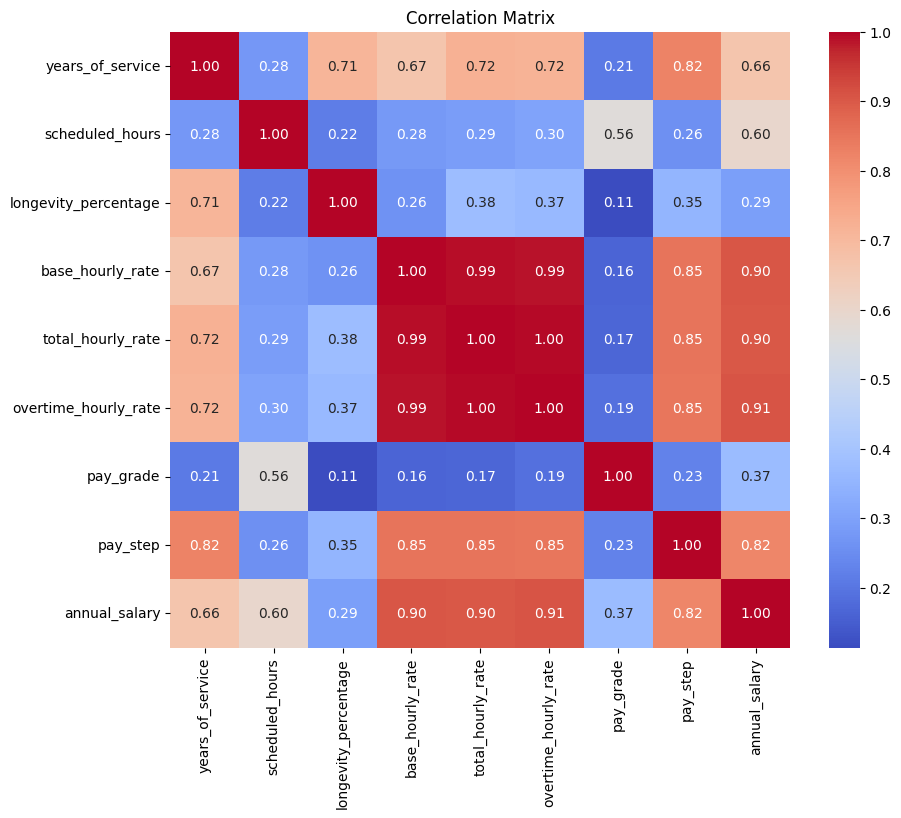

In [391]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only keep continuous variables
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]

# Plot pairplot
# sns.pairplot(numeric_df)
# plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


#### Key Insights
1. base_hourly_raye, total_hourly_rate and overtime_hourly_rate, pay_step has a high correlation with annual_salary (>0.8) <br> 
2. years_of_schedule, scheduled_hours has a moderate correlation with annual_salary (>0.5) <br>
3. years_of_service highly correlated with - longevity_percentage,total_hourly_rate, overtime_hourly_rate and pay_step <br>
4. base_hourly_rate, total_hourly_rate and overtime_hourly_rate,pay_step are highly correlated with each other. <br>


#### Overtime_ratio
Why it was created:

1. To capture the relative premium an employee earns for working overtime.

2. A higher ratio may signal roles with frequent or costly overtime — potential drivers of total compensation that base rate alone cannot explain.

3. It helps normalize differences across job titles, as some roles may have high overtime rates despite modest base pay.

Value to the model:

1. Adds granularity beyond absolute pay values.

2. Can highlight anomalies or outliers, such as roles with unusually high overtime premiums.

3. May improve predictive performance and model interpretability, especially when detecting compensation inconsistencies.



/var/folders/70/bv9d2gzn4373dn9w5fts5_f40000gp/T/ipykernel_7307/870778350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3["overtime_ratio"] = np.where(


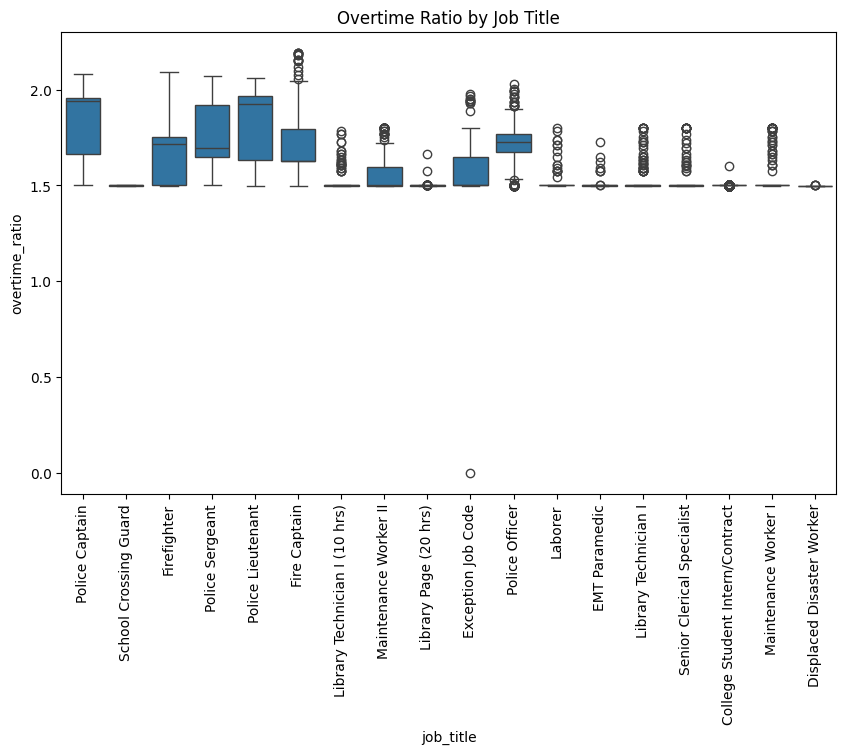

In [445]:
merged_df_3["overtime_ratio"] = np.where(
    merged_df_3['base_hourly_rate'] != 0,
    merged_df_3['overtime_hourly_rate'] / merged_df_3['base_hourly_rate'],
    0
)

# Check the distribution of overtime_ratio by job_titles
plt.figure(figsize=(10, 6))
sns.boxplot(x='job_title', y='overtime_ratio', data=merged_df_3)
plt.xticks(rotation=90)
plt.title("Overtime Ratio by Job Title")
plt.show()


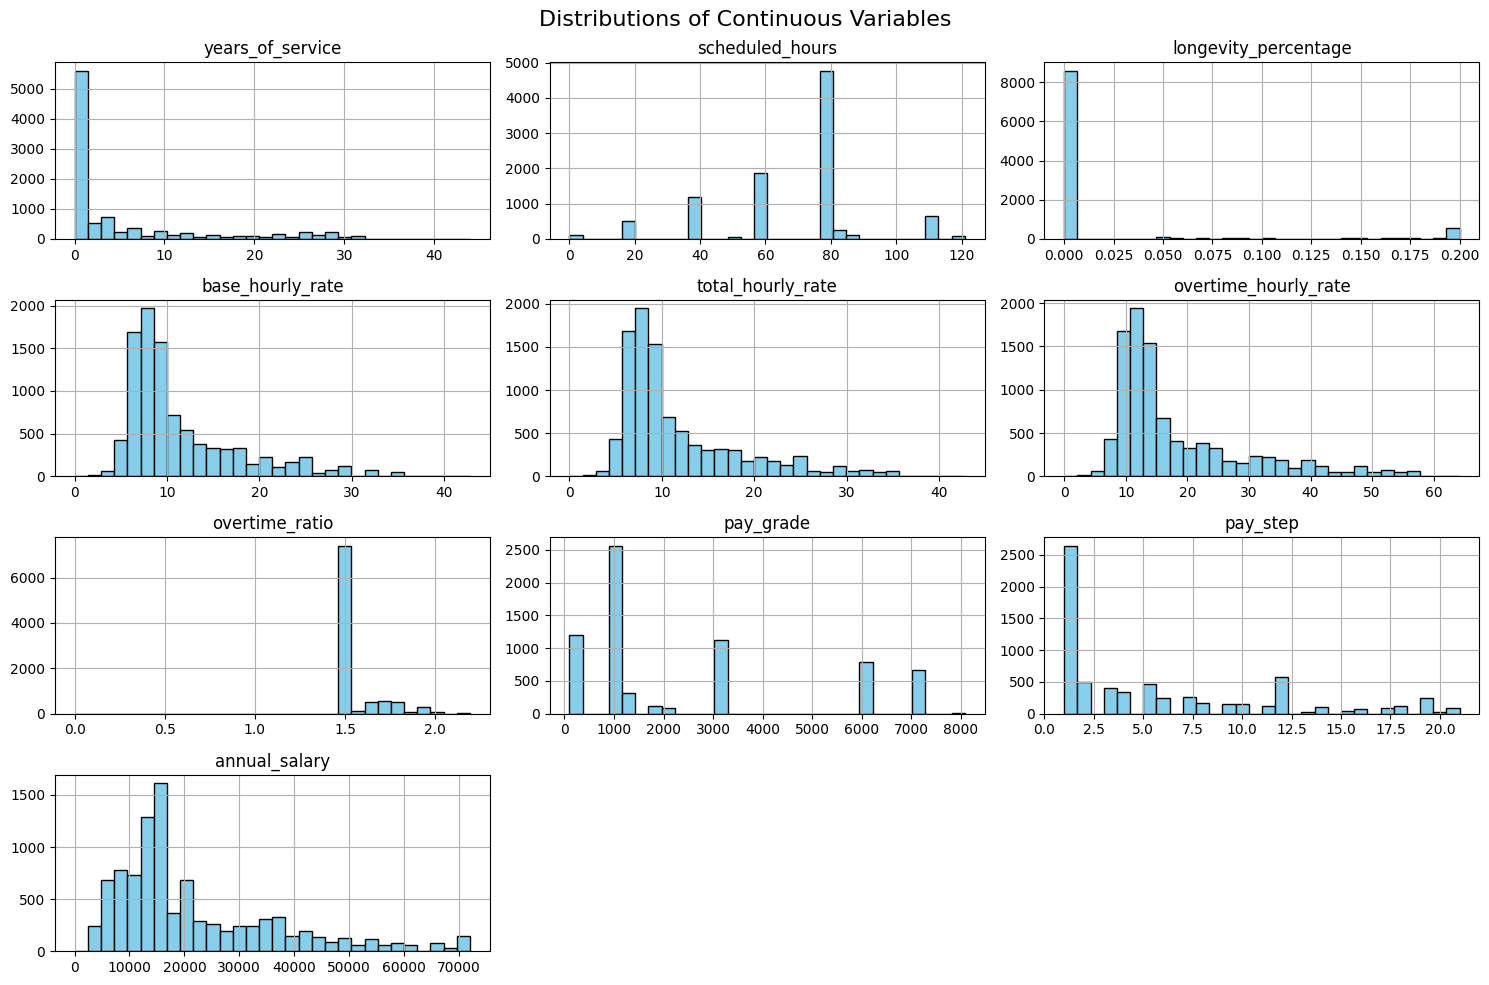

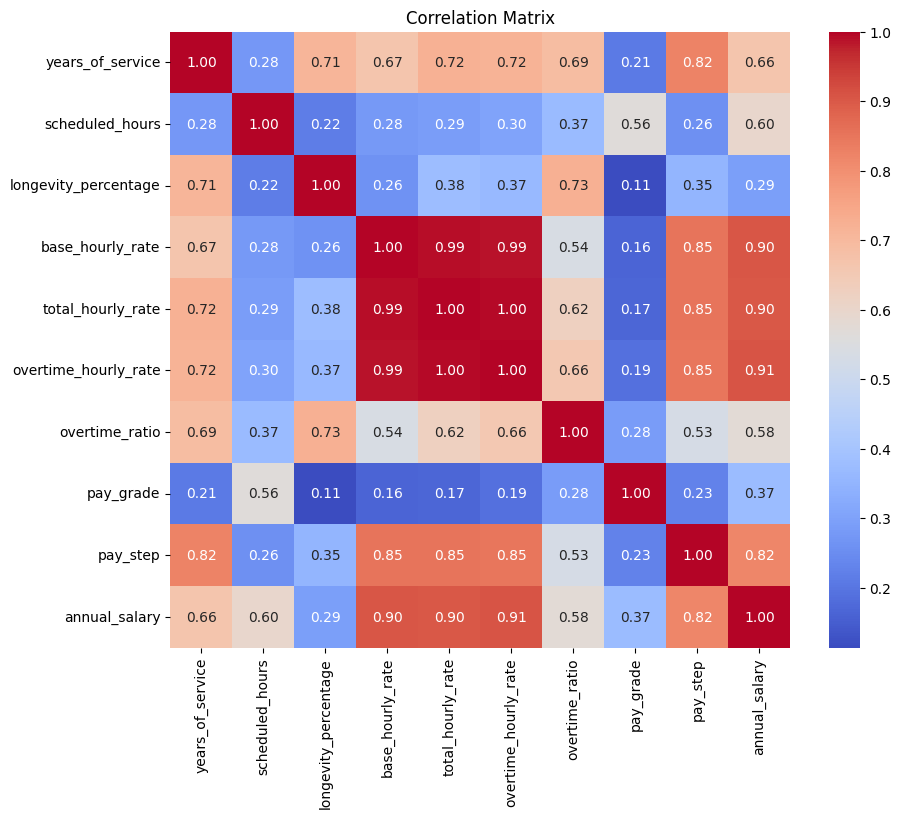

In [446]:
# Only keep continuous variables
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()




/var/folders/70/bv9d2gzn4373dn9w5fts5_f40000gp/T/ipykernel_7307/1864083512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3['log_salary'] = np.log1p(merged_df_3['annual_salary'])


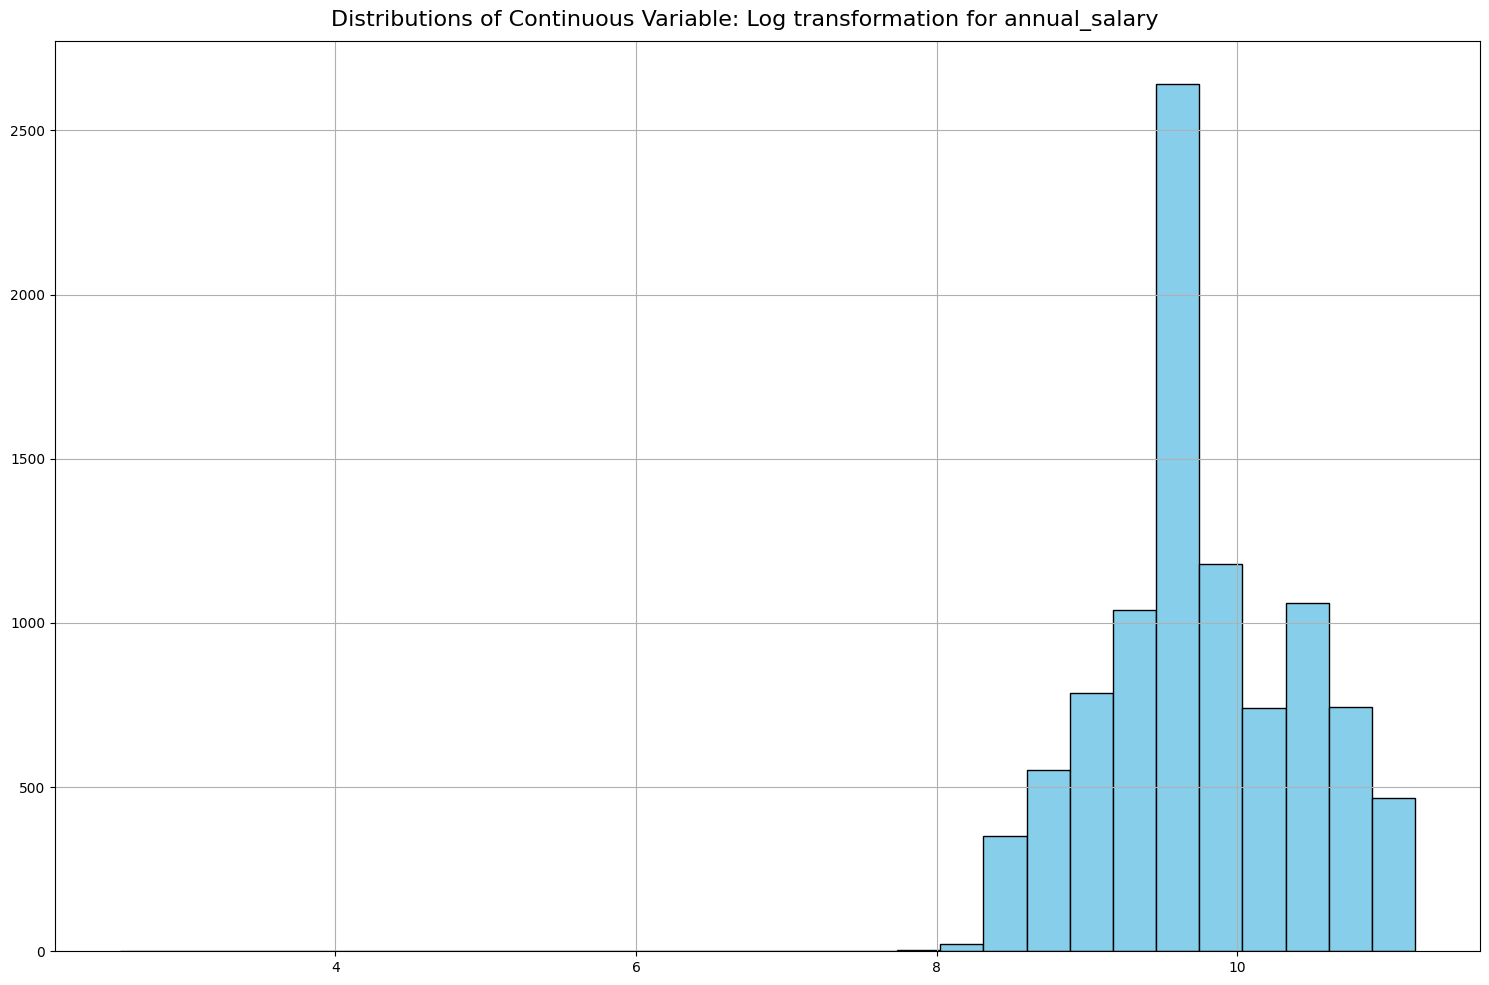

In [447]:
merged_df_3['log_salary'] = np.log1p(merged_df_3['annual_salary'])

merged_df_3['log_salary'].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variable: Log transformation for annual_salary", fontsize=16)
plt.tight_layout()
plt.show()



<Figure size 300x300 with 0 Axes>

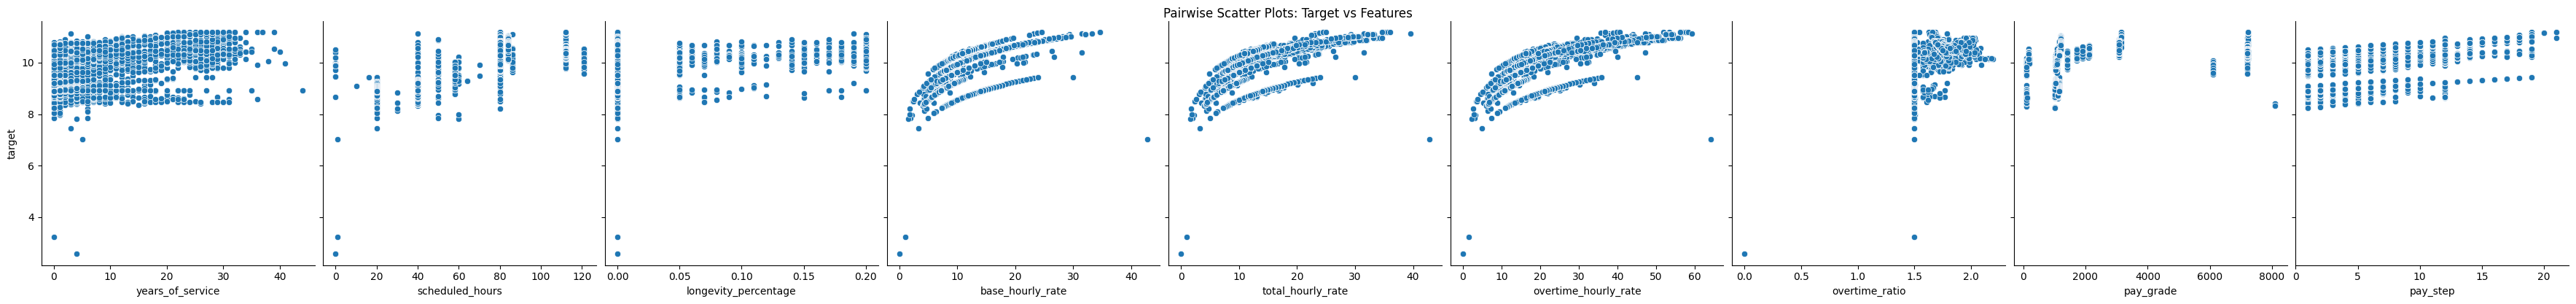

In [448]:
# Assuming X_train_dropped is your feature DataFrame and y_train is your target Series
features = ["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step"]

# Combine target and selected features into one DataFrame for plotting
plot_df = pd.concat([merged_df_3[features], merged_df_3['log_salary'].rename('target')], axis=1)

# Create scatter plots
plt.figure(figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')
sns.pairplot(plot_df, x_vars=features, y_vars='target', height=4, aspect=1, kind='scatter')
plt.suptitle('Pairwise Scatter Plots: Target vs Features', y=1.02)
plt.show()

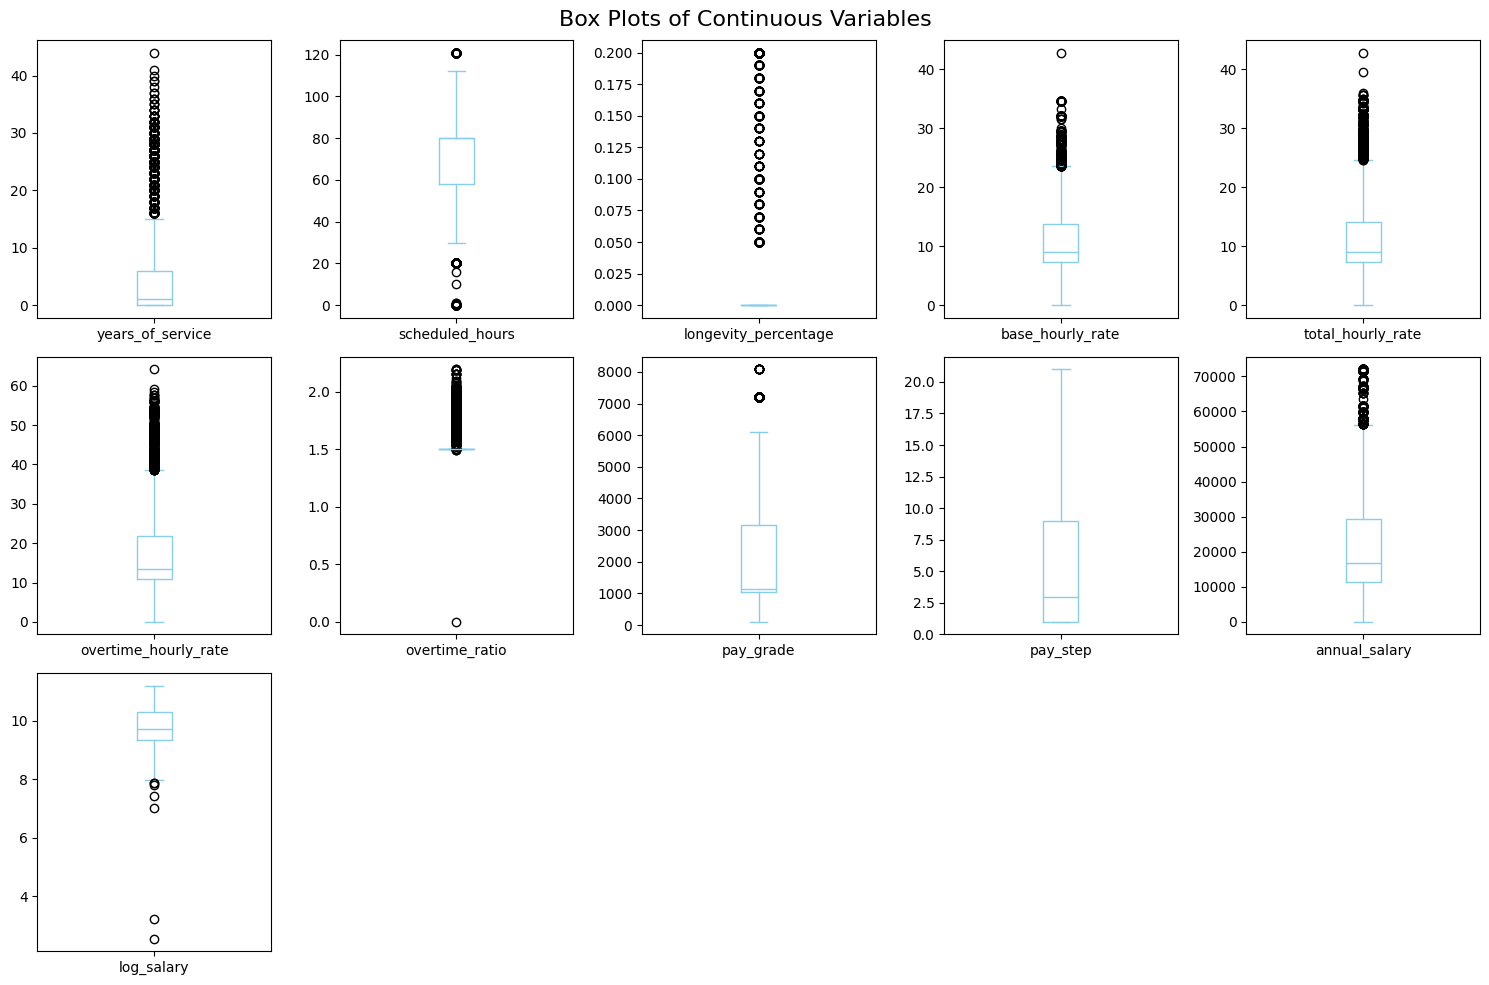

In [403]:
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
    "annual_salary",
    "log_salary"
]]

numeric_df.plot(kind='box', figsize=(15, 10), color='skyblue',subplots=True, layout=(3, 5), sharex=False, sharey=False)
plt.suptitle("Box Plots of Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [449]:
print(merged_df_3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9593 entries, 3 to 20553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pay_grade             6886 non-null   float64
 1   pay_step              6886 non-null   float64
 2   years_of_service      9593 non-null   int64  
 3   scheduled_hours       9593 non-null   float64
 4   longevity_percentage  9593 non-null   float64
 5   base_hourly_rate      9593 non-null   float64
 6   total_hourly_rate     9593 non-null   float64
 7   overtime_hourly_rate  9593 non-null   float64
 8   annual_salary         9593 non-null   float64
 9   job_title             9593 non-null   object 
 10  department_name       9593 non-null   object 
 11  overtime_ratio        9593 non-null   float64
 12  log_salary            9593 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.0+ MB
None


In [487]:
print(merged_df_3.head(5))

    pay_grade  pay_step  years_of_service  scheduled_hours  \
3      2116.0      12.0                28             80.0   
4       100.0       1.0                36             40.0   
5      7201.0       9.0                11            121.0   
8      3160.0      12.0                29             80.0   
16     3140.0      19.0                26             80.0   

    longevity_percentage  base_hourly_rate  total_hourly_rate  \
3                   0.20             17.99              21.58   
4                   0.00              5.15               5.15   
5                   0.05              6.90               8.03   
8                   0.20             27.65              33.18   
16                  0.00             29.60              29.60   

    overtime_hourly_rate  annual_salary              job_title  \
3                  34.97       37411.14         Police Captain   
4                   7.72        5356.00  School Crossing Guard   
5                  13.65       20100.0

Null values present in pay_grade and pay_step columns,decided to impute these values after splitting to Train and Test set

In [451]:
#Define features and target
X = merged_df_3.drop(columns=['annual_salary', 'log_salary'])
y = merged_df_3['log_salary']

print("X columns:",X.columns)



#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X columns: Index(['pay_grade', 'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'job_title', 'department_name',
       'overtime_ratio'],
      dtype='object')


In [452]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
X_train[['pay_grade', 'pay_step']] = knn_imputer.fit_transform(X_train[['pay_grade', 'pay_step']])
X_test[['pay_grade', 'pay_step']] = knn_imputer.transform(X_test[['pay_grade', 'pay_step']])

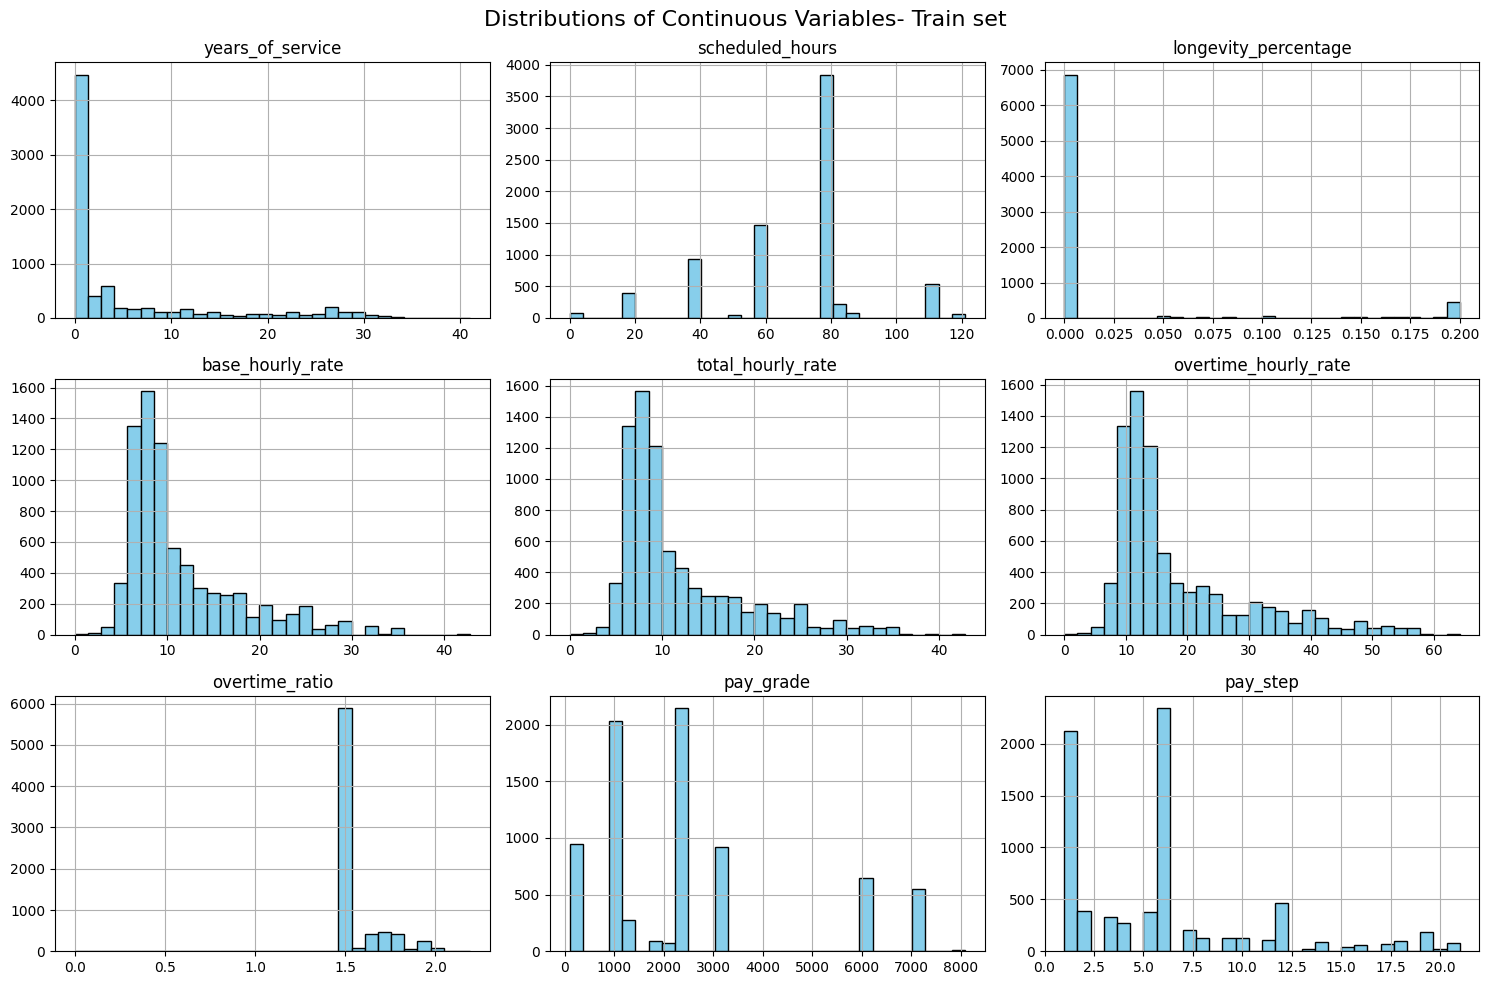

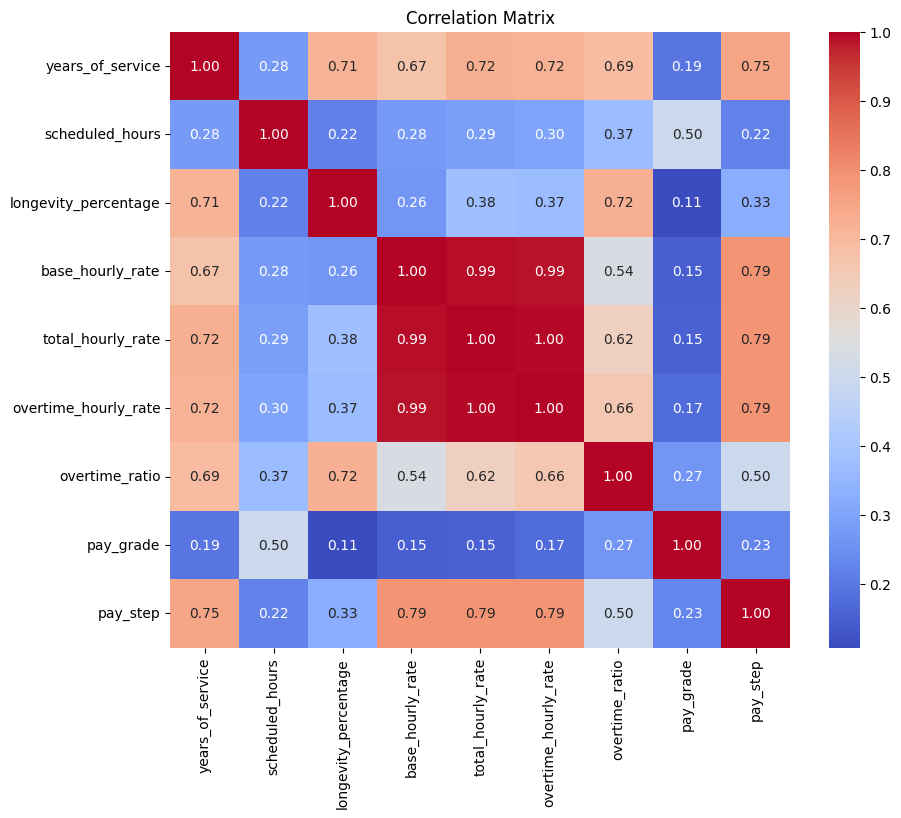

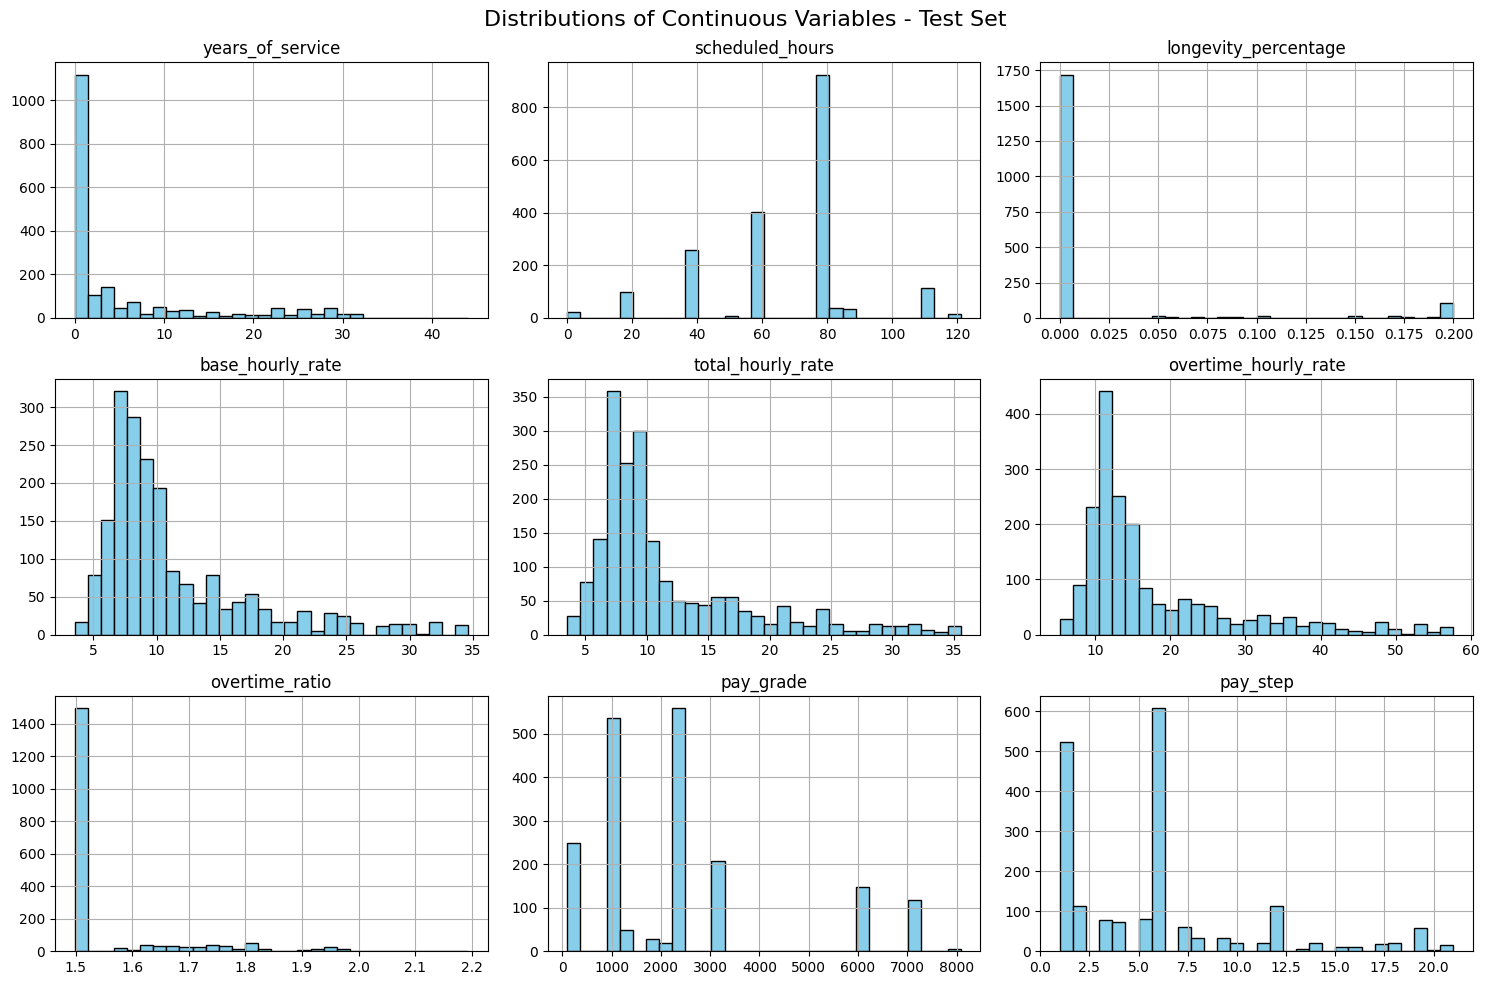

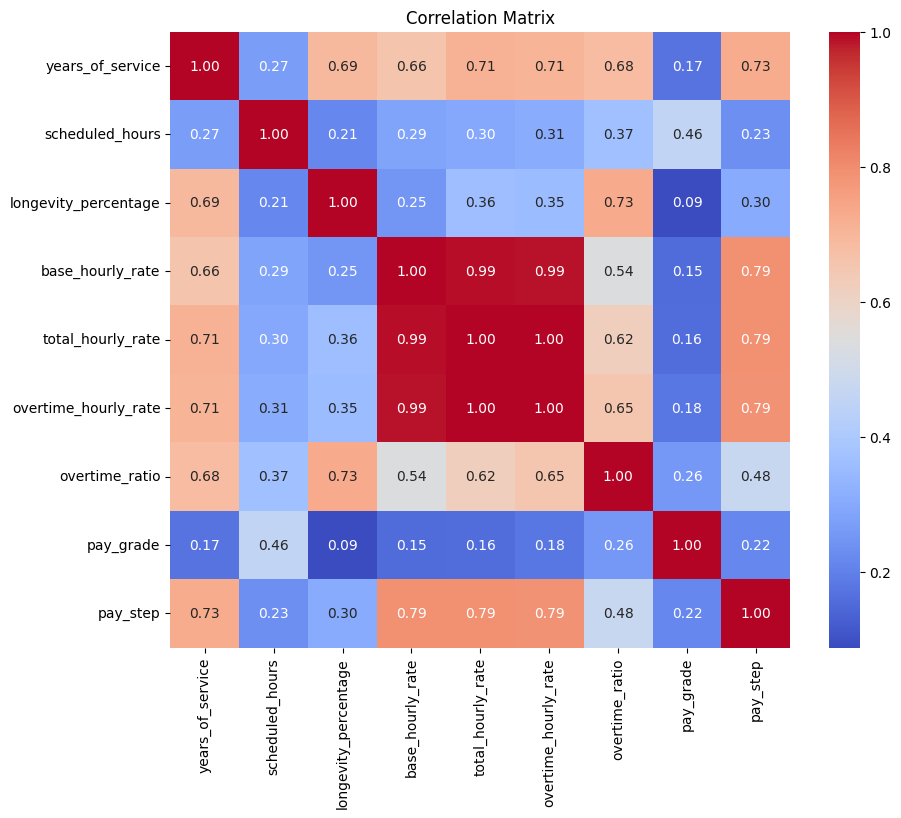

In [453]:
# Only keep continuous variables
numeric_df = X_train[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables- Train set", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



# Only keep continuous variables
numeric_df = X_test[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables - Test Set", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



#### One hot Encoding For job_title

In [454]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Initialize encoder with correct settings
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Step 2: Fit on training set ONLY
encoder.fit(X_train[['job_title']])

# Step 3: Transform train and test
train_encoded = encoder.transform(X_train[['job_title']])
test_encoded = encoder.transform(X_test[['job_title']])

# Step 4: Convert to DataFrames with matching indices and correct column names
encoded_train_df = pd.DataFrame(train_encoded, 
                                columns=encoder.get_feature_names_out(['job_title']),
                                index=X_train.index)

encoded_test_df = pd.DataFrame(test_encoded, 
                               columns=encoder.get_feature_names_out(['job_title']),
                               index=X_test.index)

# Step 5: Drop the original 'job_title' column and concatenate the encoded DataFrames
X_train_encode = pd.concat([X_train.drop('job_title', axis=1), encoded_train_df], axis=1)
X_test_encode = pd.concat([X_test.drop('job_title', axis=1), encoded_test_df], axis=1)

X_train_encode = X_train_encode.drop(columns=['department_name'])
X_test_encode = X_test_encode.drop(columns=['department_name'])


In [ ]:
# # Step 2: Fit on training set ONLY
# encoder.fit(X_train_encode_1[['department_name']])

# # Step 3: Transform train and test
# train_encoded = encoder.transform(X_train_encode_1[['department_name']])
# test_encoded = encoder.transform(X_test_encode_1[['department_name']])

# # Step 4: Convert to DataFrames from the encoded arrays
# encoded_train_df = pd.DataFrame(train_encoded, 
#                                 columns=encoder.get_feature_names_out(['department_name']),
#                                 index=X_train_encode_1.index)

# encoded_test_df = pd.DataFrame(test_encoded, 
#                                columns=encoder.get_feature_names_out(['department_name']),
#                                index=X_test_encode_1.index)

# # Step 5: Drop the original 'department_name' column and concatenate the encoded DataFrames
# X_train_encode_final = pd.concat([X_train_encode_1.drop('department_name', axis=1), encoded_train_df], axis=1)
# X_test_encode_final = pd.concat([X_test_encode_1.drop('department_name', axis=1), encoded_test_df], axis=1)

# print(X_train_encode_final.shape, X_test_encode_final.shape)


In [417]:
# Checking null values in Train and test set
print(X_train_encode.info())
print(X_test_encode.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7674 entries, 7929 to 16185
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   pay_grade                                7674 non-null   float64
 1   pay_step                                 7674 non-null   float64
 2   years_of_service                         7674 non-null   int64  
 3   scheduled_hours                          7674 non-null   float64
 4   longevity_percentage                     7674 non-null   float64
 5   base_hourly_rate                         7674 non-null   float64
 6   total_hourly_rate                        7674 non-null   float64
 7   overtime_hourly_rate                     7674 non-null   float64
 8   overtime_ratio                           7674 non-null   float64
 9   job_title_Displaced Disaster Worker      7674 non-null   float64
 10  job_title_EMT Paramedic                  7674 non

#### Checking Train and Test Distribution

In [455]:
import pandas as pd

def compare_distributions(train_df, test_df, features):
    summary = []
    for f in features:
        train_stats = train_df[f].describe()
        test_stats = test_df[f].describe()
        summary.append({
            'feature': f,
            'train_mean': train_stats['mean'],
            'test_mean': test_stats['mean'],
            'train_std': train_stats['std'],
            'test_std': test_stats['std'],
            'mean_diff': abs(train_stats['mean'] - test_stats['mean']),
            'std_diff': abs(train_stats['std'] - test_stats['std']),
        })
    return pd.DataFrame(summary)


features_to_check = ['pay_grade', 'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'overtime_ratio',
       'job_title_Displaced Disaster Worker', 'job_title_EMT Paramedic',
       'job_title_Exception Job Code', 'job_title_Fire Captain',
       'job_title_Firefighter', 'job_title_Laborer',
       'job_title_Library Page (20 hrs)', 'job_title_Library Technician I',
       'job_title_Library Technician I (10 hrs)',
       'job_title_Maintenance Worker I', 'job_title_Maintenance Worker II',
       'job_title_Police Captain', 'job_title_Police Lieutenant',
       'job_title_Police Officer', 'job_title_Police Sergeant',
       'job_title_School Crossing Guard',
       'job_title_Senior Clerical Specialist']
compare_distributions(X_train_encode, X_test_encode, features_to_check)

,feature,train_mean,test_mean,train_std,test_std,mean_diff,std_diff
0,pay_grade,2488.062240,2388.228168,2012.494637,1957.364392,99.834072,55.130245
1,pay_step,5.691514,5.639004,4.819497,4.799809,0.052511,0.019688
2,years_of_service,5.224003,5.251694,8.645320,8.684885,0.027690,0.039566
3,scheduled_hours,69.536878,68.323606,22.817210,22.742999,1.213272,0.074210
4,longevity_percentage,0.017021,0.016774,0.052693,0.052195,0.000247,0.000498
5,base_hourly_rate,11.442458,11.225925,6.091655,6.017389,0.216533,0.074267
6,total_hourly_rate,11.753855,11.520167,6.530605,6.425804,0.233688,0.104801
7,overtime_hourly_rate,18.276840,17.869849,10.892896,10.714936,0.406991,0.177960
8,overtime_ratio,1.560943,1.556901,0.126564,0.121395,0.004042,0.005169
9,job_title_Displaced Disaster Worker,0.022413,0.021365,0.148033,0.144637,0.001048,0.003397


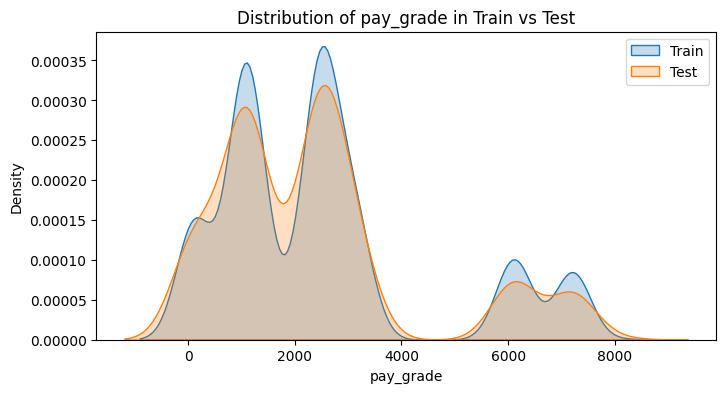

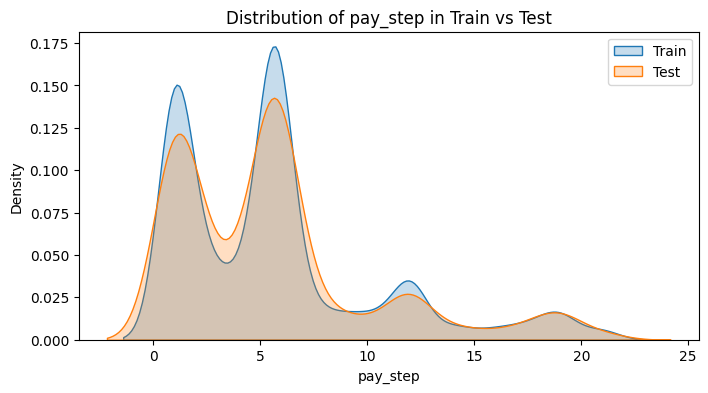

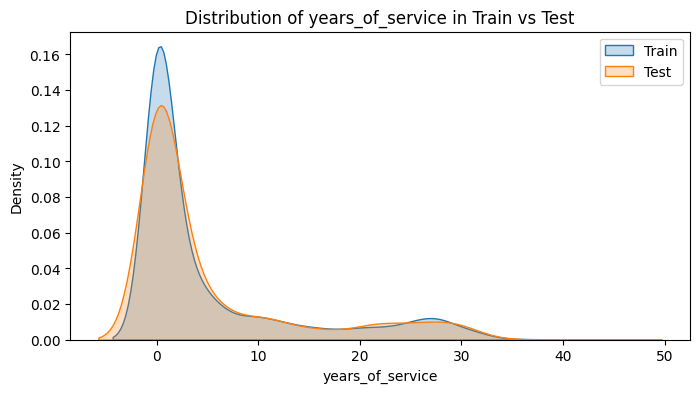

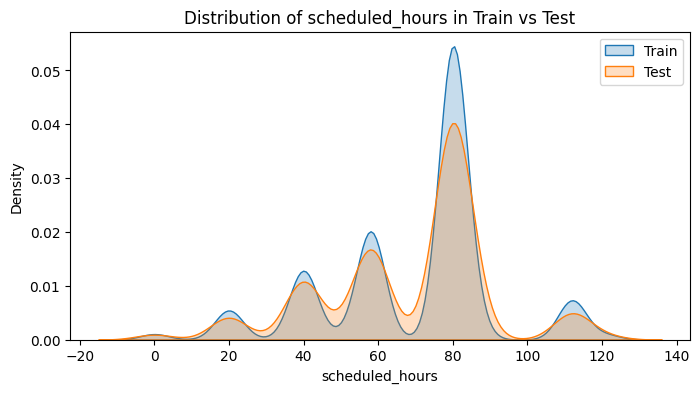

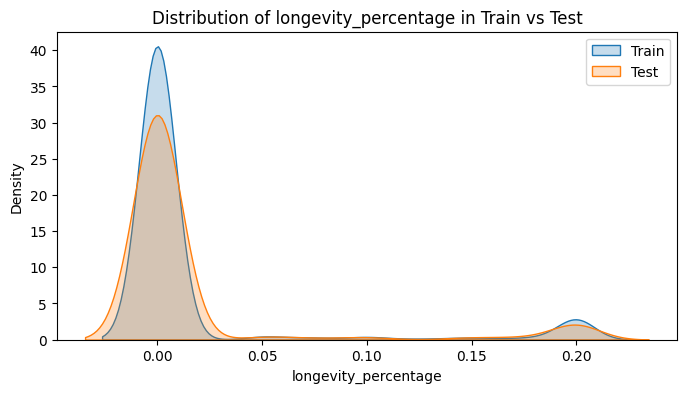

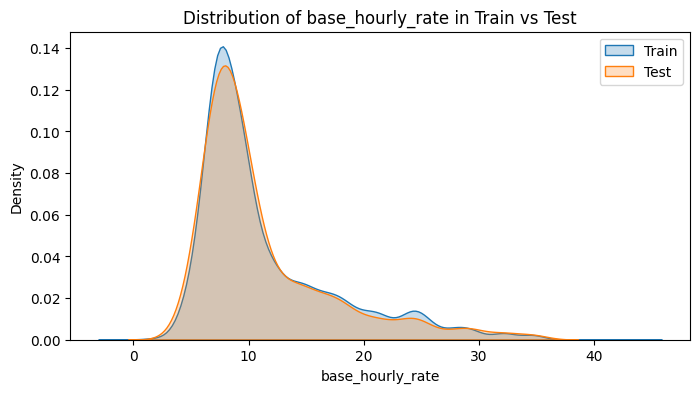

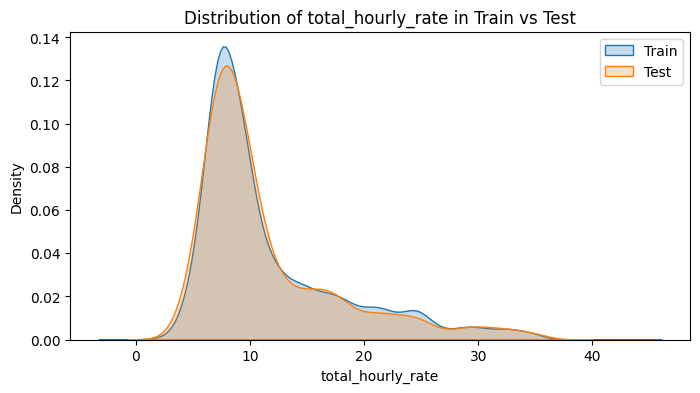

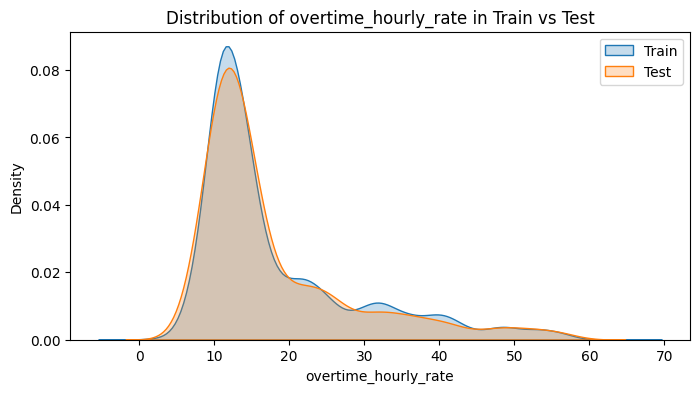

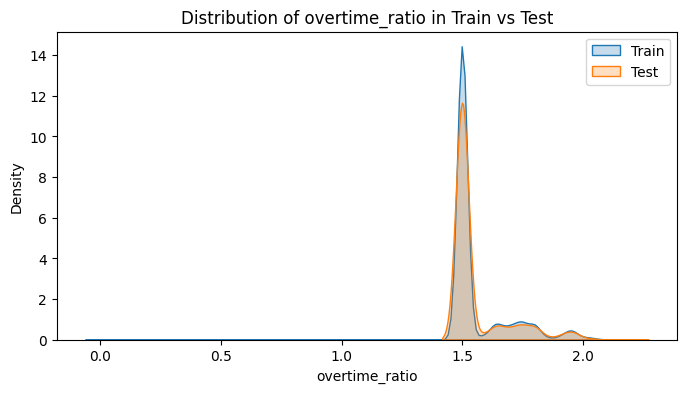

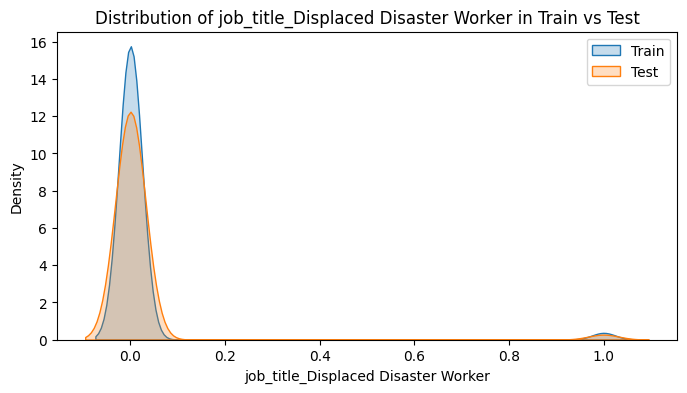

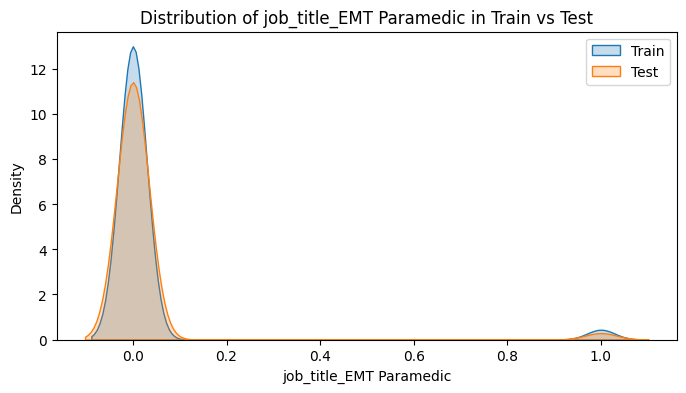

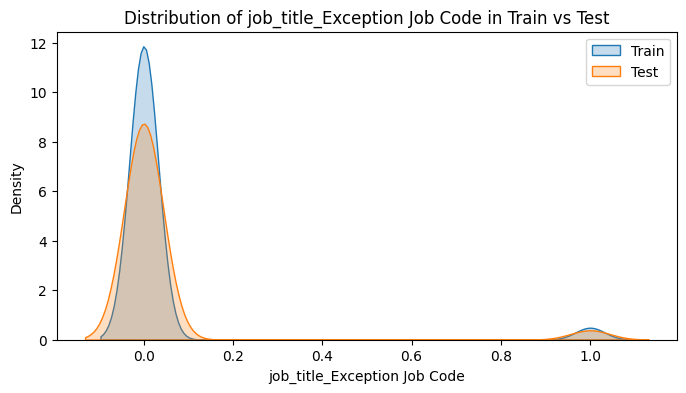

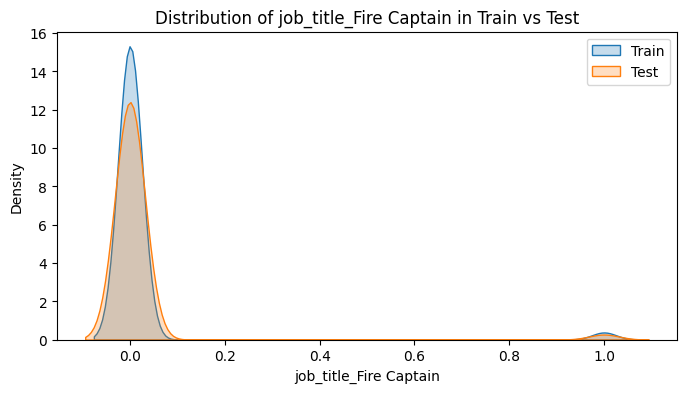

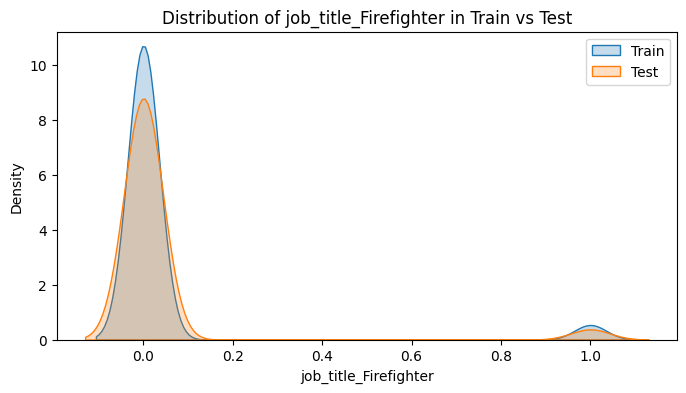

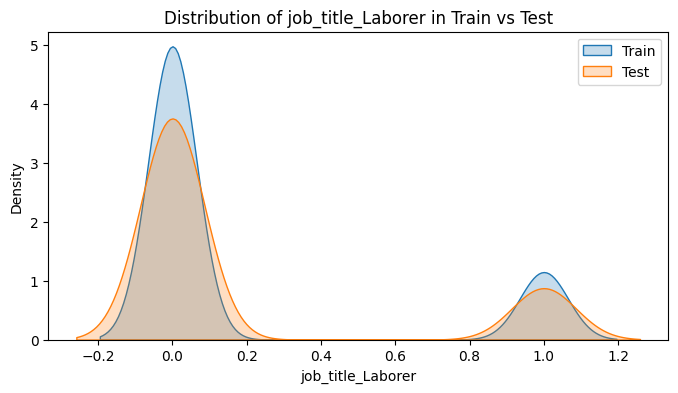

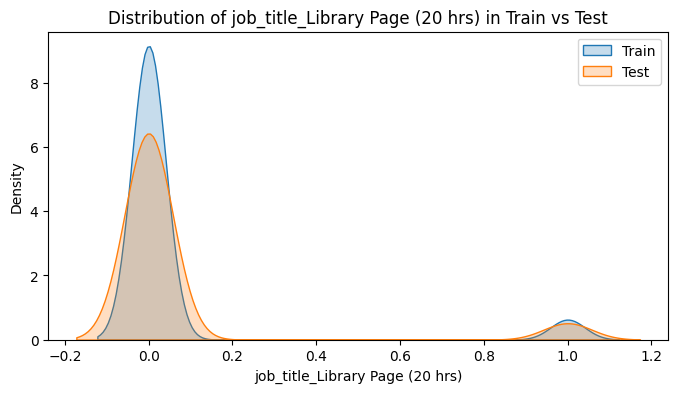

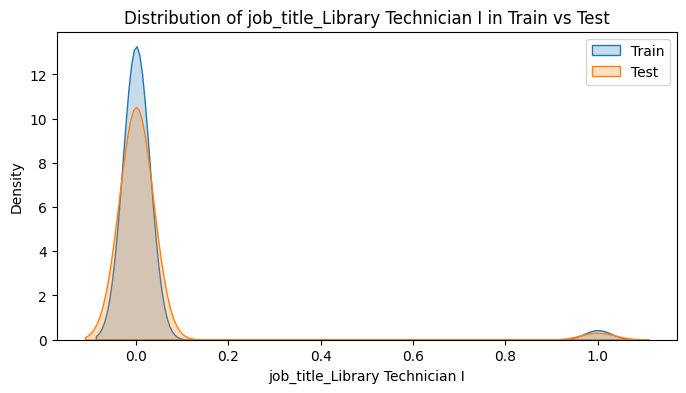

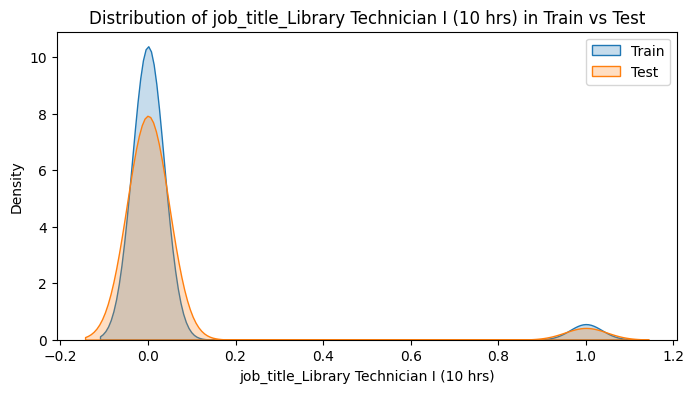

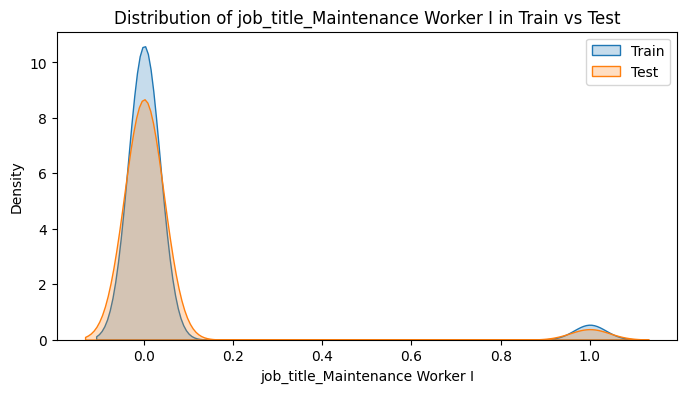

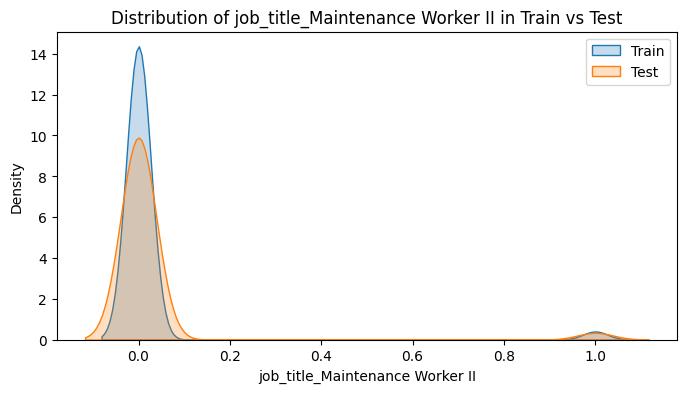

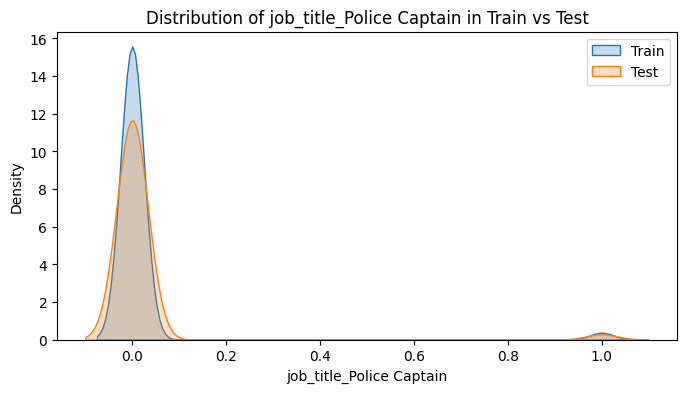

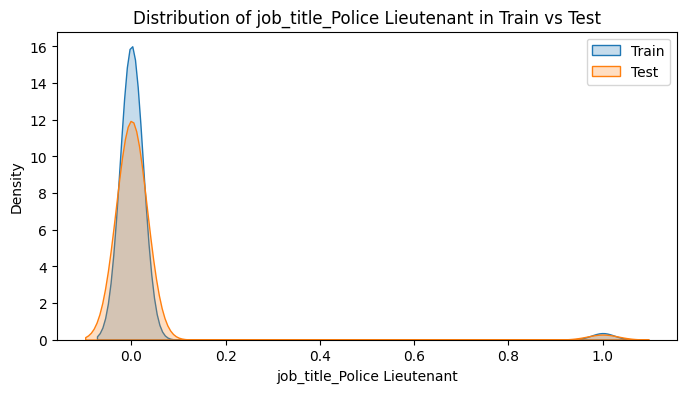

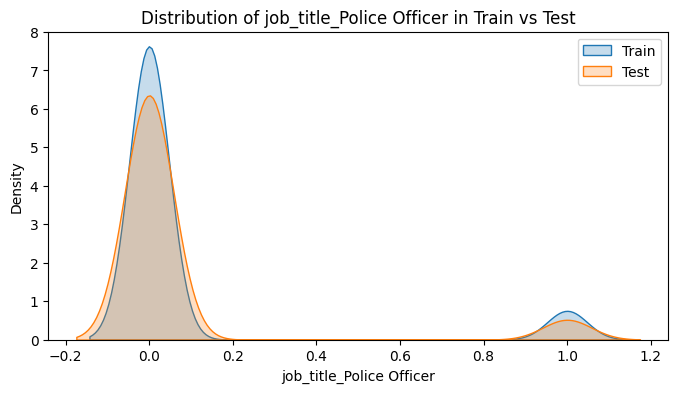

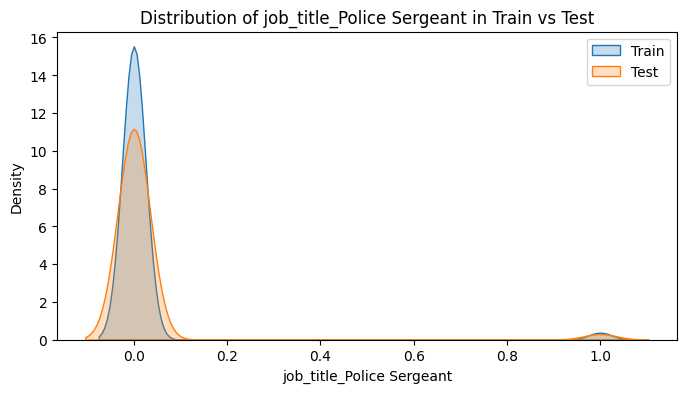

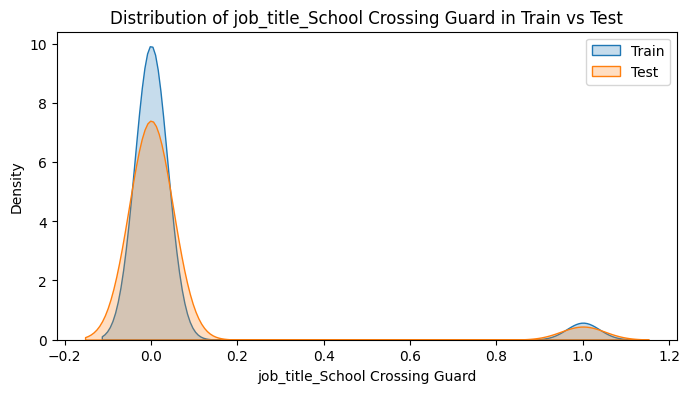

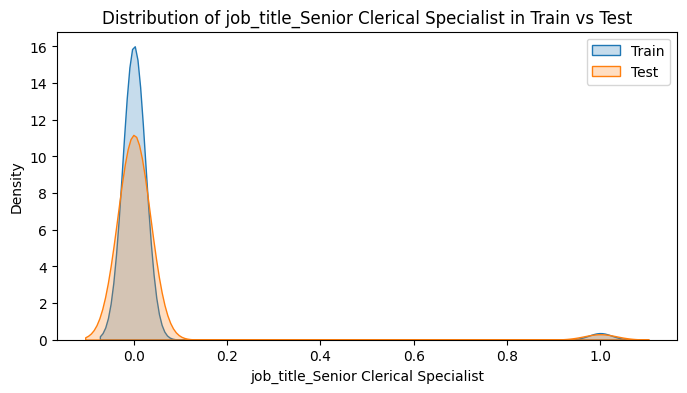

In [456]:
import matplotlib.pyplot as plt
import seaborn as sns

for f in features_to_check:
    plt.figure(figsize=(8,4))
    sns.kdeplot(X_train_encode[f], label='Train', fill=True)
    sns.kdeplot(X_test_encode[f], label='Test', fill=True)
    plt.title(f'Distribution of {f} in Train vs Test')
    plt.legend()
    plt.show()

In [457]:
from scipy.stats import ks_2samp

for f in features_to_check:
    stat, p = ks_2samp(X_train_encode[f], X_test_encode[f])
    print(f'{f}: KS stat={stat:.4f}, p-value={p:.4f}')


pay_grade: KS stat=0.0288, p-value=0.1522
pay_step: KS stat=0.0127, p-value=0.9627
years_of_service: KS stat=0.0066, p-value=1.0000
scheduled_hours: KS stat=0.0296, p-value=0.1325
longevity_percentage: KS stat=0.0042, p-value=1.0000
base_hourly_rate: KS stat=0.0324, p-value=0.0778
total_hourly_rate: KS stat=0.0307, p-value=0.1080
overtime_hourly_rate: KS stat=0.0308, p-value=0.1053
overtime_ratio: KS stat=0.0256, p-value=0.2593
job_title_Displaced Disaster Worker: KS stat=0.0010, p-value=1.0000
job_title_EMT Paramedic: KS stat=0.0081, p-value=0.9999
job_title_Exception Job Code: KS stat=0.0022, p-value=1.0000
job_title_Fire Captain: KS stat=0.0029, p-value=1.0000
job_title_Firefighter: KS stat=0.0067, p-value=1.0000
job_title_Laborer: KS stat=0.0015, p-value=1.0000
job_title_Library Page (20 hrs): KS stat=0.0098, p-value=0.9983
job_title_Library Technician I: KS stat=0.0026, p-value=1.0000
job_title_Library Technician I (10 hrs): KS stat=0.0007, p-value=1.0000
job_title_Maintenance Wor

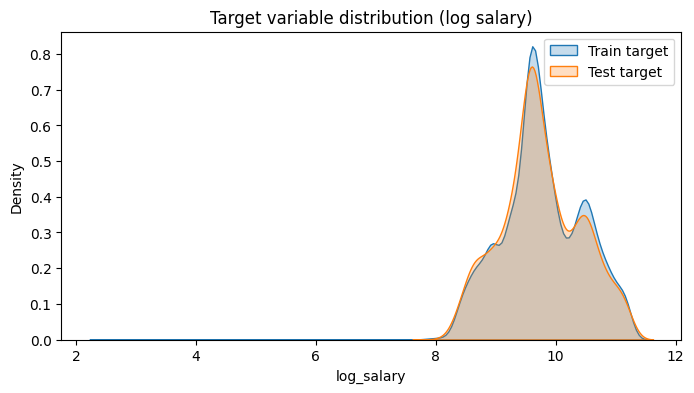

In [458]:
plt.figure(figsize=(8,4))
sns.kdeplot(y_train, label='Train target', fill=True)
sns.kdeplot(y_test, label='Test target', fill=True)
plt.title("Target variable distribution (log salary)")
plt.legend()
plt.show()

#### Variation Inflation Factor

In [459]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



X = add_constant(X_train_encode)

vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vif)

                                   features          VIF
0                                     const  2243.179547
1                                 pay_grade     2.316036
2                                  pay_step     6.418263
3                          years_of_service     9.141604
4                           scheduled_hours     7.954190
5                      longevity_percentage    10.428400
6                          base_hourly_rate   403.033830
7                         total_hourly_rate   718.555594
8                      overtime_hourly_rate   684.481852
9                            overtime_ratio    14.755655
10      job_title_Displaced Disaster Worker     1.120719
11                  job_title_EMT Paramedic     2.229333
12             job_title_Exception Job Code     1.599676
13                   job_title_Fire Captain     3.000567
14                    job_title_Firefighter     4.117037
15                        job_title_Laborer     3.202429
16          job_title_Library P

##### Dropping 'base_hourly_rate','overtime_hourly_rate','years_of_service'

In [462]:
X_train_encode_final = X_train_encode.drop(columns=['base_hourly_rate','overtime_hourly_rate','years_of_service'])
X_test_encode_final = X_test_encode.drop(columns=['base_hourly_rate','overtime_hourly_rate','years_of_service'])
print(X_train_encode_final.shape, X_test_encode_final.shape)
print(X_train_encode_final.columns)

(7674, 23) (1919, 23)
Index(['pay_grade', 'pay_step', 'scheduled_hours', 'longevity_percentage',
       'total_hourly_rate', 'overtime_ratio',
       'job_title_Displaced Disaster Worker', 'job_title_EMT Paramedic',
       'job_title_Exception Job Code', 'job_title_Fire Captain',
       'job_title_Firefighter', 'job_title_Laborer',
       'job_title_Library Page (20 hrs)', 'job_title_Library Technician I',
       'job_title_Library Technician I (10 hrs)',
       'job_title_Maintenance Worker I', 'job_title_Maintenance Worker II',
       'job_title_Police Captain', 'job_title_Police Lieutenant',
       'job_title_Police Officer', 'job_title_Police Sergeant',
       'job_title_School Crossing Guard',
       'job_title_Senior Clerical Specialist'],
      dtype='object')


#### Checking Variation Inflation Factor after removing 'base_hourly_rate','overtime_hourly_rate','years_of_service'

In [463]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



X = add_constant(X_train_encode_final)

vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vif)

                                   features         VIF
0                                     const  850.862384
1                                 pay_grade    2.308763
2                                  pay_step    4.232559
3                           scheduled_hours    7.763851
4                      longevity_percentage    3.608558
5                         total_hourly_rate    8.177395
6                            overtime_ratio    5.793513
7       job_title_Displaced Disaster Worker    1.115503
8                   job_title_EMT Paramedic    2.118503
9              job_title_Exception Job Code    1.447961
10                   job_title_Fire Captain    2.961353
11                    job_title_Firefighter    4.083502
12                        job_title_Laborer    3.106939
13          job_title_Library Page (20 hrs)    1.707099
14           job_title_Library Technician I    1.655102
15  job_title_Library Technician I (10 hrs)    2.567189
16           job_title_Maintenance Worker I    1

In [486]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode_final)
X_test_scaled = scaler.transform(X_test_encode_final)
print(X_train_scaled)

[[ 1.79934577e+00 -1.43492025e-01  4.58592623e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]
 [-2.25976743e-16  1.84300606e-16  4.58592623e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]
 [-6.39577410e-01  4.79020081e-01  6.33910319e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]
 ...
 [ 1.79835191e+00 -9.73508166e-01  4.58592623e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]
 [-5.32737865e-01  6.40120102e-02  7.21569168e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]
 [-2.25976743e-16  1.84300606e-16 -5.05654710e-01 ... -1.53653649e-01
  -2.40015619e-01 -1.48693475e-01]]


#### Fitting a baseline Regression Model

Mean Squared Error: 0.013536473732027777
R-squared: 0.9692317580414089
Coefficients:
                                         Coefficient
total_hourly_rate                           0.479150
scheduled_hours                             0.162105
job_title_Firefighter                       0.075843
job_title_Displaced Disaster Worker         0.067493
job_title_Laborer                           0.050144
job_title_Police Officer                    0.047755
job_title_Maintenance Worker I              0.043107
job_title_EMT Paramedic                     0.041527
job_title_Library Technician I              0.039447
job_title_Fire Captain                      0.039443
job_title_Senior Clerical Specialist        0.037695
job_title_Maintenance Worker II             0.036833
overtime_ratio                              0.021925
job_title_Exception Job Code               -0.000158
job_title_Police Sergeant                  -0.009243
longevity_percentage                       -0.009286
pay_grade     

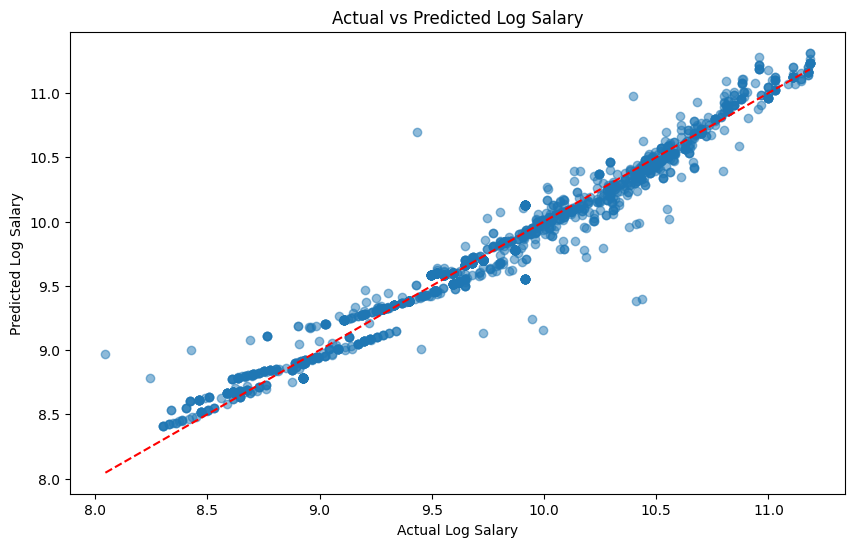

In [478]:
# Fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Print coefficients
coefficients = pd.DataFrame(model.coef_, X_train_encode_final.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Log Salary')
plt.ylabel('Predicted Log Salary')
plt.title('Actual vs Predicted Log Salary')
plt.show()

The baseline regression model shows strong predictive performance, with a low Mean Squared Error (0.0135) and a high R-squared value of 0.969, indicating that the model explains about 97% of the variance in the target variable. Among the features, total_hourly_rate has the largest positive impact on the outcome, while scheduled_hours also contributes positively but to a lesser extent. Some job titles have notable effects, for example, Firefighter and Displaced Disaster Worker are associated with positive coefficients, while Library Technician I (10 hrs) and School Crossing Guard have negative associations. Overall, the coefficients reflect how pay grades, hours worked, job roles, and other factors influence the predicted value.

In [467]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline with scaling and ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Hyperparameter tuning for alpha (regularization strength)
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_encode_final, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
r2_test = best_model.score(X_test_encode_final, y_test)
print("Test R2:", r2_test)


Best alpha: {'ridge__alpha': 10}
Best CV R2: 0.9461371647700384
Test R2: 0.9693222876432689


In [468]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline: scaling + Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Grid of alpha values to try
param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_encode_final, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

best_model = grid_search.best_estimator_
r2_test = best_model.score(X_test_encode_final, y_test)
print("Test R2:", r2_test)

# Get feature coefficients
coefs = best_model.named_steps['lasso'].coef_
feature_importance = pd.Series(coefs, index=X_train_encode_final.columns)

# Get std deviation of target
y_std = y_train.std()

# Get std dev of each feature (from original X, not scaled!)
X_std = X_train_encode_final.std()
X_std = X_std.replace(0, np.nan)  # prevent divide-by-zero


unstandardized_coef = coefs * y_std / X_std
unstandardized_coef = unstandardized_coef.replace([np.inf, -np.inf], np.nan) 

# Put in DataFrame for easier reading
coef_df = pd.DataFrame({
    'feature': X_train_encode_final.columns,
    'standardized_coef': coefs,
    'unstandardized_coef': unstandardized_coef
})
print("Top features (by unstandardized impact on salary):")
print(coef_df.sort_values(by='unstandardized_coef', ascending=False).head(10))
print("Bottom features:")
print(coef_df.sort_values(by='unstandardized_coef', ascending=True).head(10))


Best alpha: {'lasso__alpha': 0.001}
Best CV R2: 0.9468481870455008
Test R2: 0.9690090904910305
Top features (by unstandardized impact on salary):
                                                                   feature  \
job_title_Displaced Disaster Worker    job_title_Displaced Disaster Worker   
job_title_Firefighter                                job_title_Firefighter   
job_title_Senior Clerical Specialist  job_title_Senior Clerical Specialist   
job_title_EMT Paramedic                            job_title_EMT Paramedic   
job_title_Library Technician I              job_title_Library Technician I   
job_title_Fire Captain                              job_title_Fire Captain   
job_title_Maintenance Worker II            job_title_Maintenance Worker II   
job_title_Maintenance Worker I              job_title_Maintenance Worker I   
job_title_Police Officer                          job_title_Police Officer   
job_title_Laborer                                        job_title_Laborer

<Figure size 1500x1000 with 0 Axes>

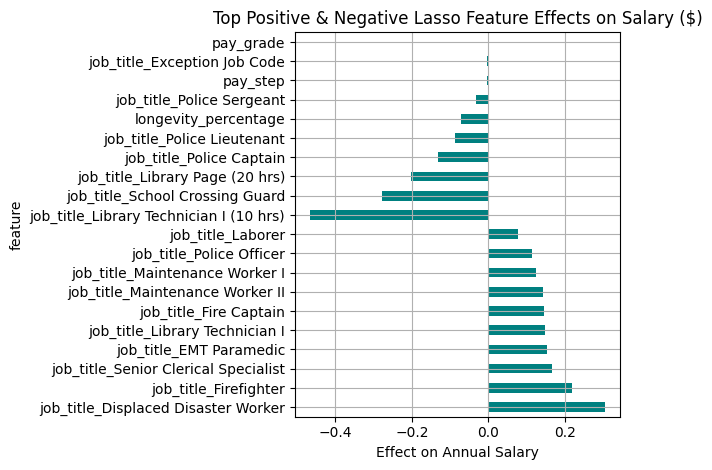

In [469]:
import matplotlib.pyplot as plt

top = coef_df.sort_values(by='unstandardized_coef', ascending=False).head(10)
bottom = coef_df.sort_values(by='unstandardized_coef', ascending=True).head(10)

plt.figure(figsize=(15, 10))
pd.concat([top, bottom]).plot(kind='barh', x='feature', y='unstandardized_coef', color='teal', legend=False)
plt.title('Top Positive & Negative Lasso Feature Effects on Salary ($)')
plt.xlabel('Effect on Annual Salary')
plt.grid(True)
plt.tight_layout()
plt.show()


Test R2: 0.9958


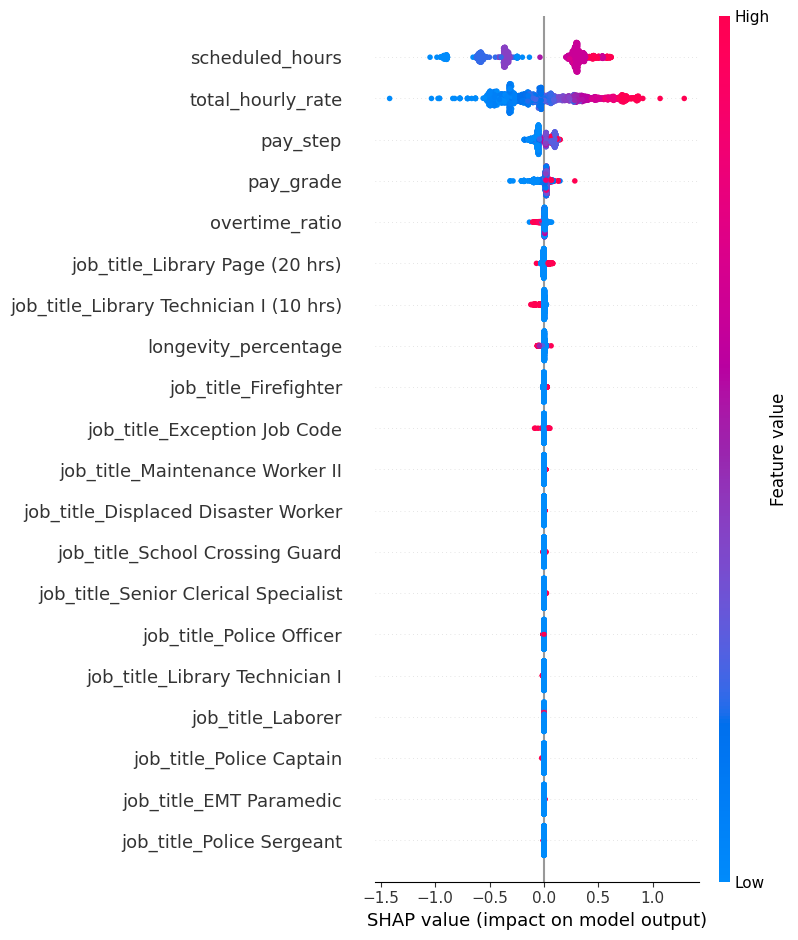

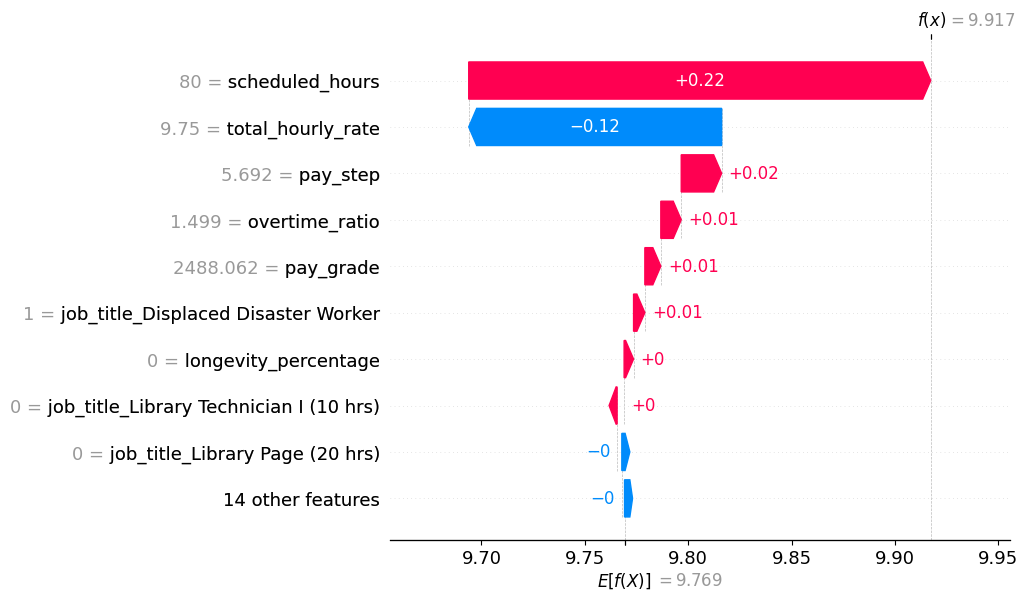

In [470]:
import xgboost as xgb
from sklearn.metrics import r2_score
import shap

# 1. Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_encode_final, y_train)

# 2. Evaluate model
y_pred = xgb_model.predict(X_test_encode_final)
print(f"Test R2: {r2_score(y_test, y_pred):.4f}")

# 3. Initialize SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_encode_final)

# 4. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test_encode_final)

# 5. SHAP waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])


In [432]:
import pickle
xgb_model.get_booster().feature_names


with open('/Users/suvedharam/payroll-prediction/model/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


In [433]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train_encode_final, y_train, cv=5, scoring='r2')
print(f"CV R2 scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")


CV R2 scores: [0.93180199 0.9697807  0.9395792  0.92008332 0.97299572]
Mean CV R2: 0.9468, Std: 0.0210


In [489]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Train the model
print(X_train_encode_final.shape, X_train_encode_final.shape)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encode_final, y_train)

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test_encode_final)

from sklearn.metrics import r2_score, mean_squared_error
print("Test R2:", r2_score(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
print("RMSE:", np.sqrt(mse))


(7674, 23) (7674, 23)
Test R2: 0.9940758590218093
RMSE: 0.05105216025422272


Feature importances: (23,)
Feature names: (23,)


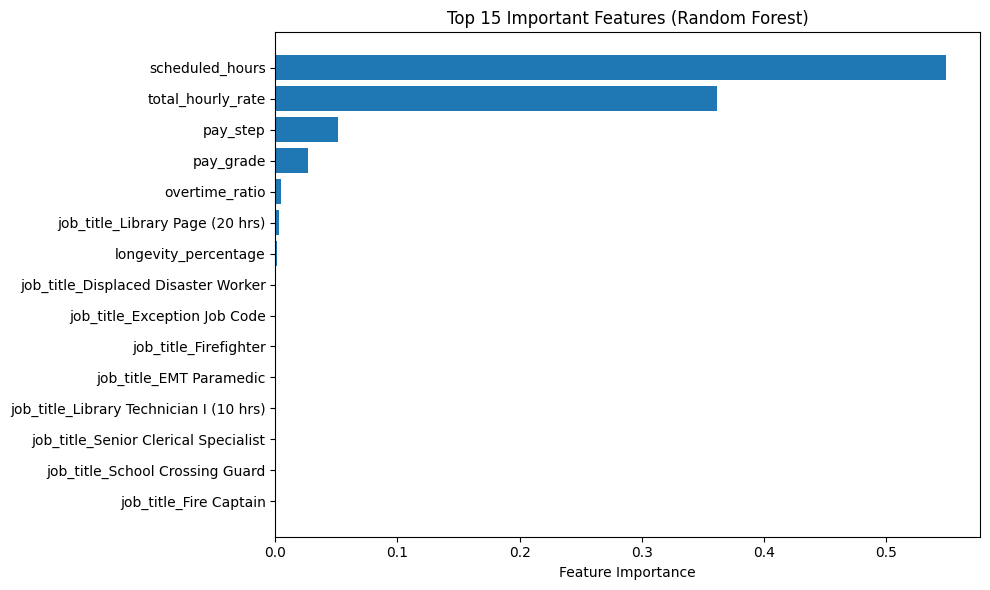

In [473]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from RF
importances = rf_model.feature_importances_
feature_names = X_train_encode_final.columns
print("Feature importances:", importances.shape)
print("Feature names:", feature_names.shape)
feat_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['feature'][:15][::-1], feat_importance_df['importance'][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


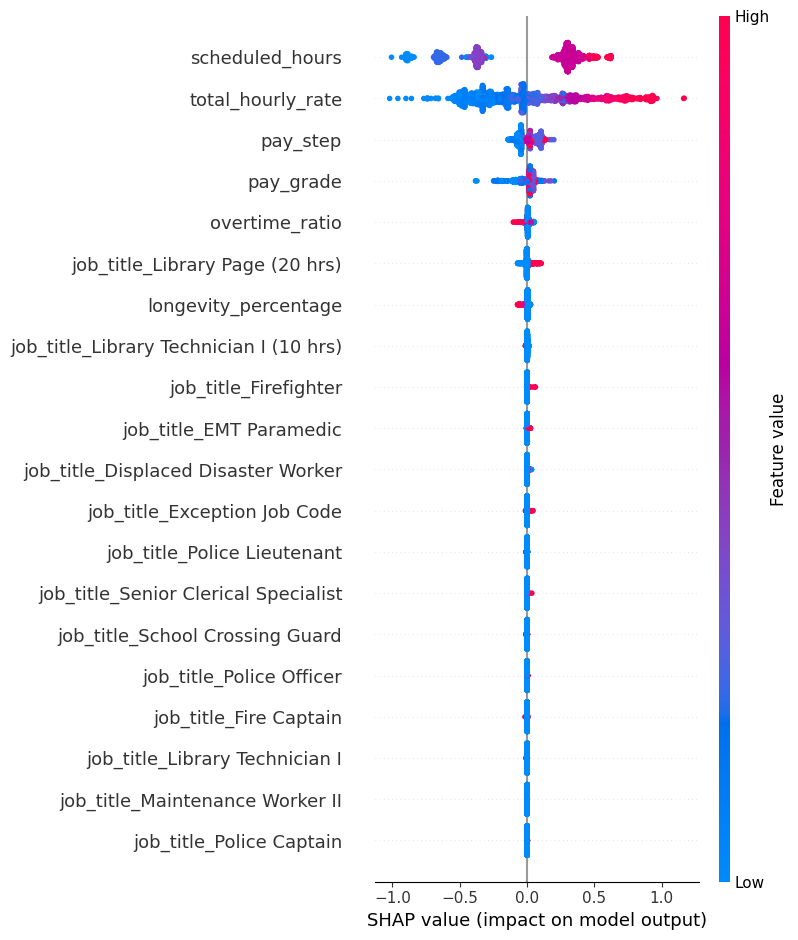

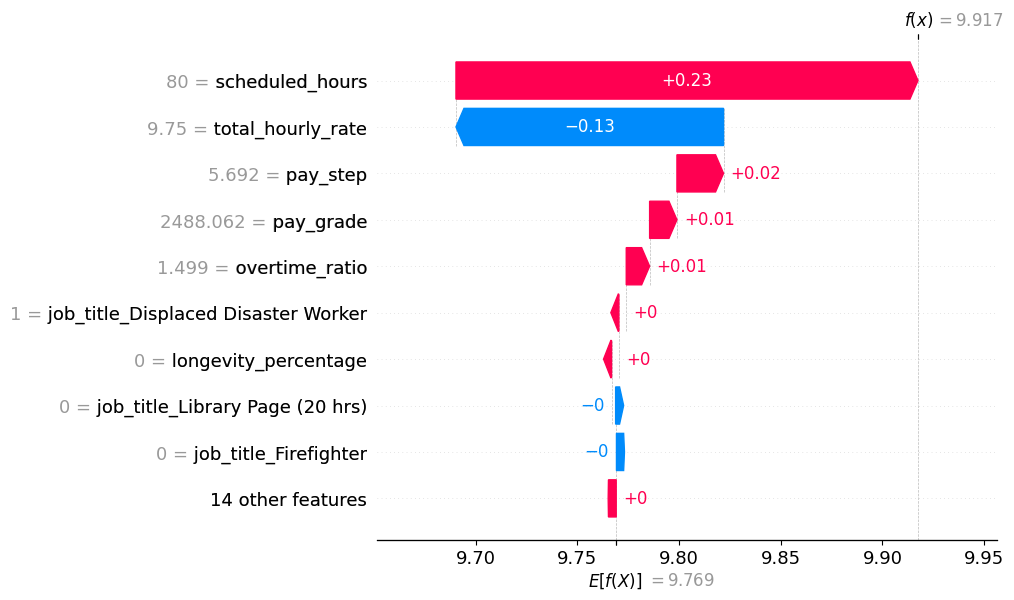

In [475]:
# 3. Initialize SHAP explainer
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_encode_final)

# 4. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test_encode_final)

# 5. SHAP waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])


In [480]:
import pickle
xgb_model.get_booster().feature_names


with open('/Users/suvedharam/payroll-prediction/model/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [490]:
# Calculate residual standard deviation from your test predictions
residuals = y_test - y_pred_rf
residual_std = np.std(residuals, ddof=1)

print(f"Residual Standard Deviation: {residual_std:.6f}")
print(f"Use this in your Streamlit app: residual_std = {residual_std:.6f}")

Residual Standard Deviation: 0.051056
Use this in your Streamlit app: residual_std = 0.051056


In [491]:
# ===== ADD THIS CODE TO CALCULATE RESIDUAL STD =====

# Method 1: Calculate residual standard deviation from test set
def calculate_residual_std(y_true, y_pred):
    """Calculate residual standard deviation"""
    residuals = y_true - y_pred
    residual_std = np.std(residuals, ddof=1)  # ddof=1 for sample standard deviation
    return residual_std, residuals

# Calculate residual std from your test set
residual_std_test, residuals_test = calculate_residual_std(y_test, y_pred_rf)

print(f"\n=== RESIDUAL STANDARD DEVIATION ===")
print(f"Residual Std (test set): {residual_std_test:.6f}")
print(f"This is the value to use in your Streamlit app!")

# Method 2: More robust - Cross-validated residual std
from sklearn.model_selection import cross_val_predict

print(f"\n=== CROSS-VALIDATED RESIDUAL STD (More Robust) ===")
# Combine your train and test data for full cross-validation
X_full = np.vstack([X_train_encode_final, X_test_encode_final])
y_full = np.concatenate([y_train, y_test])

# Get cross-validated predictions
y_pred_cv = cross_val_predict(rf_model, X_full, y_full, cv=5)
residual_std_cv, residuals_cv = calculate_residual_std(y_full, y_pred_cv)

print(f"Residual Std (cross-validated): {residual_std_cv:.6f}")
print(f"Recommended value for Streamlit: {residual_std_cv:.6f}")

# Method 3: Calculate different threshold options
print(f"\n=== ANOMALY DETECTION THRESHOLDS ===")
thresholds_std = [1.5, 2.0, 2.5, 3.0]
for thresh in thresholds_std:
    threshold_value = thresh * residual_std_cv
    print(f"{thresh}×std = {threshold_value:.6f} (flags ~{100*(1-0.68**thresh):.1f}% as anomalies)")

# Method 4: Analyze residuals
def analyze_residuals(residuals, residual_std):
    """Analyze residual distribution"""
    print(f"\n=== RESIDUAL ANALYSIS ===")
    print(f"Residual Statistics:")
    print(f"  Mean: {np.mean(residuals):.6f}")
    print(f"  Std: {np.std(residuals, ddof=1):.6f}")
    print(f"  Min: {np.min(residuals):.6f}")
    print(f"  Max: {np.max(residuals):.6f}")
    print(f"  25th percentile: {np.percentile(residuals, 25):.6f}")
    print(f"  75th percentile: {np.percentile(residuals, 75):.6f}")
    
    # Check for outliers using different thresholds
    for thresh in [2, 3]:
        outliers = np.abs(residuals) > (thresh * residual_std)
        pct_outliers = np.sum(outliers) / len(residuals) * 100
        print(f"  {thresh}×std outliers: {np.sum(outliers)} ({pct_outliers:.1f}%)")

analyze_residuals(residuals_cv, residual_std_cv)

# Method 5: Convert to salary terms for interpretation
def interpret_in_salary_terms(residual_std_log, y_test_log):
    """Convert log-space residual std to salary interpretation"""
    print(f"\n=== INTERPRETATION IN SALARY TERMS ===")
    
    # Calculate relative error percentage
    relative_error_pct = (np.exp(residual_std_log) - 1) * 100
    print(f"Residual std of {residual_std_log:.6f} in log space =")
    print(f"Roughly ±{relative_error_pct:.1f}% relative error in salary")
    
    # For different salary levels, show absolute dollar impact
    salary_examples = [30000, 50000, 75000, 100000]
    print(f"\nAbsolute dollar impact examples:")
    for salary in salary_examples:
        upper_bound = salary * np.exp(residual_std_log)
        lower_bound = salary * np.exp(-residual_std_log)
        print(f"  ${salary:,}: ±1std range ${lower_bound:,.0f} to ${upper_bound:,.0f}")

# Run interpretation (assuming your y_test is in log space)
interpret_in_salary_terms(residual_std_cv, y_test)

# Method 6: Save the values for your Streamlit app
def save_residual_std_config(residual_std, filename='model_config.py'):
    """Save residual std and thresholds for Streamlit app"""
    config_content = f'''# Model Configuration for Streamlit App
# Generated automatically from training results

# Residual standard deviation (in log space)
RESIDUAL_STD = {residual_std:.6f}

# Anomaly detection thresholds
THRESHOLD_2_STD = {2 * residual_std:.6f}
THRESHOLD_3_STD = {3 * residual_std:.6f}

# For Streamlit app, use:
# residual_std = {residual_std:.6f}
'''
    
    with open(filename, 'w') as f:
        f.write(config_content)
    
    print(f"\n=== SAVED CONFIG ===")
    print(f"Configuration saved to {filename}")
    print(f"Use this in your Streamlit app:")
    print(f"residual_std = {residual_std:.6f}")

# Save the configuration
save_residual_std_config(residual_std_cv)

# Method 7: Quick verification that your model predictions are in log space
print(f"\n=== MODEL OUTPUT VERIFICATION ===")
print(f"Sample predictions from model: {y_pred_rf[:5]}")
print(f"Sample actual values: {y_test[:5]}")
print(f"Are these in log space? Check if values are around 9-12 (log of salary)")

if np.mean(y_pred_rf) > 8 and np.mean(y_pred_rf) < 15:
    print("✓ Predictions appear to be in log space")
else:
    print("⚠ Predictions might not be in log space - double check!")

# Final recommendation
print(f"\n" + "="*50)
print(f"FINAL RECOMMENDATION FOR STREAMLIT APP:")
print(f"residual_std = {residual_std_cv:.6f}")
print(f"This gives you robust anomaly detection thresholds:")
print(f"  2×std = {2*residual_std_cv:.6f} (conservative)")
print(f"  3×std = {3*residual_std_cv:.6f} (strict)")
print(f"="*50)


=== RESIDUAL STANDARD DEVIATION ===
Residual Std (test set): 0.051056
This is the value to use in your Streamlit app!

=== CROSS-VALIDATED RESIDUAL STD (More Robust) ===
Residual Std (cross-validated): 0.076563
Recommended value for Streamlit: 0.076563

=== ANOMALY DETECTION THRESHOLDS ===
1.5×std = 0.114844 (flags ~43.9% as anomalies)
2.0×std = 0.153125 (flags ~53.8% as anomalies)
2.5×std = 0.191407 (flags ~61.9% as anomalies)
3.0×std = 0.229688 (flags ~68.6% as anomalies)

=== RESIDUAL ANALYSIS ===
Residual Statistics:
  Mean: -0.001044
  Std: 0.076563
  Min: -4.437554
  Max: 1.463005
  25th percentile: -0.000000
  75th percentile: 0.000000
  2×std outliers: 72 (0.8%)
  3×std outliers: 51 (0.5%)

=== INTERPRETATION IN SALARY TERMS ===
Residual std of 0.076563 in log space =
Roughly ±8.0% relative error in salary

Absolute dollar impact examples:
  $30,000: ±1std range $27,789 to $32,387
  $50,000: ±1std range $46,315 to $53,978
  $75,000: ±1std range $69,472 to $80,968
  $100,000: ±